# Odd Ball

## Dataframes and Cleaning

In [2]:
import pandas as pd
import numpy as np
import requests

### Elo DataFrames

These DataFrames contain the ELO score scraped from clubelo.com for each of the clubs in the premier league for the passed three seasons.

I think this will be one of the strongest coefficients for predicting the outcome of a game.

In [ ]:
clubs = ['Burnley', 'CrystalPalace', 'Everton', 'Hull',
       'ManCity', 'Middlesbrough', 'Southampton', 'Arsenal',
       'Bournemouth', 'Chelsea', 'ManUnited', 'Leicester',
       'Stoke', 'Swansea', 'Tottenham', 'Watford',
       'WestBrom', 'Sunderland', 'WestHam',
       'Liverpool', 'Brighton', 'Newcastle',
       'Huddersfield', 'Fulham', 'Wolves', 'Cardiff']

In [ ]:
# Commented out so don't accidently run the scraper unnecesarily
# You need to run this if doing from scratch though

# for i in clubs:
#     csv = requests.get('http://api.clubelo.com/{}'.format(i))
    
#     with open('{}.csv'.format(i), 'w+') as f:
#         f.write(csv.text)  

In [ ]:
# create an empty df to append the cleaned csv's to

all_elo = pd.DataFrame()

In [ ]:
for i in clubs:
    
    df_maker = pd.read_csv('{}.csv'.format(i)) # open each csv
    
    # convert date column to datetime format
    try:
        df_maker['Date'] = pd.to_datetime(df_maker['To'], format='%Y/%m/%d')
    except:
        df_maker['Date'] = pd.to_datetime(df_maker['To'], format='%d/%m/%Y')
     
    # make the date column the index
    df_maker.set_index('Date', inplace=True, drop=True)
    
    # drop unnecessary columns
    df_maker.drop(columns=['From', 'To', 'Level', 'Country', 'Rank'], inplace=True)
    
    # subset the data so that only the relevant periods are kept
    df_maker = df_maker[(df_maker.index <= '2019-06') & (df_maker.index >= '2016-08')]
    
    # combine cleaned df with all_elo
    all_elo = pd.concat([all_elo, df_maker])

In [ ]:
all_elo.shape

In [ ]:
# need to see the formatting of the club names, this needs to be consistent as I plan to use a portion
# of the club names and the date column to create unique keys for merging dataframes later

all_elo.Club.unique()

In [ ]:
# Changing the format of some of the clubs

all_elo['Club'] = ['ManUtd' if i=='Man United' else i for i in all_elo['Club']]
all_elo['Club'] = ['ManCity' if i=='Man City' else i for i in all_elo['Club']]
all_elo['Club'] = ['WestHam' if i=='West Ham' else i for i in all_elo['Club']]
all_elo['Club'] = ['WestBrom' if i=='West Brom' else i for i in all_elo['Club']]
all_elo['Club'] = ['HullCity' if i=='Hull' else i for i in all_elo['Club']]

In [ ]:
# creating a unique key for merging dataframes later

all_elo['key'] = [str(i)+n[:5] for i,n in zip(all_elo.index, all_elo['Club'])]

In [ ]:
# look! a histogram!

all_elo.plot(kind='hist');

### Five_38 Dataset

This is the dataset I am going to use as my main dataset. I plan on appending the market values of the clubs as well as the ELO's of the clubs to this one. I alos need to do some feature engineering and clean/remove some of these columns.

In [32]:
five_38 = pd.read_csv('csv/spi_matches.csv')

In [33]:
five_38.head()

,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,probtie,...,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
0,2016-08-12,1843,French Ligue 1,Bastia,Paris Saint-Germain,51.16,85.68,0.0463,0.8380,0.1157,...,32.4,67.7,0.0,1.0,0.97,0.63,0.43,0.45,0.00,1.05
1,2016-08-12,1843,French Ligue 1,AS Monaco,Guingamp,68.85,56.48,0.5714,0.1669,0.2617,...,53.7,22.9,2.0,2.0,2.45,0.77,1.75,0.42,2.10,2.10
2,2016-08-13,2411,Barclays Premier League,Hull City,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,...,38.1,22.2,2.0,1.0,0.85,2.77,0.17,1.25,2.10,1.05
3,2016-08-13,2411,Barclays Premier League,Crystal Palace,West Bromwich Albion,55.19,58.66,0.4214,0.2939,0.2847,...,43.6,34.6,0.0,1.0,1.11,0.68,0.84,1.60,0.00,1.05
4,2016-08-13,2411,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,...,31.9,48.0,1.0,1.0,0.73,1.11,0.88,1.81,1.05,1.05


In [34]:
five_38['league'].unique()

array(['French Ligue 1', 'Barclays Premier League',
       'Spanish Primera Division', 'Italy Serie A', 'German Bundesliga',
       'UEFA Champions League',
       'Mexican Primera Division Torneo Clausura', 'Major League Soccer',
       'Swedish Allsvenskan', 'Norwegian Tippeligaen',
       "National Women's Soccer League", 'Brasileiro Série A',
       'Russian Premier Liga', 'Mexican Primera Division Torneo Apertura',
       'Austrian T-Mobile Bundesliga', 'Swiss Raiffeisen Super League',
       'French Ligue 2', 'German 2. Bundesliga',
       'English League Championship', 'Scottish Premiership',
       'Portuguese Liga', 'Dutch Eredivisie',
       'Turkish Turkcell Super Lig', 'Spanish Segunda Division',
       'Italy Serie B', 'Argentina Primera Division',
       'UEFA Europa League', 'United Soccer League', 'Danish SAS-Ligaen',
       'Belgian Jupiler League', 'Japanese J League',
       'Chinese Super League', 'English League One',
       'South African ABSA Premier League', 'En

In [35]:
# change date column to datetime

five_38['date'] = pd.to_datetime(five_38['date'], format='%Y-%m-%d')

In [36]:
# make it the index

five_38.set_index('date', inplace=True, drop=True)

In [37]:
# make it prettier

five_38.index.name = None

In [38]:
# Selecting only the premier league and only the last three seasons

epl = five_38[(five_38['league_id'] == 2411) & (five_38.index <= '2019-07')]

In [39]:
epl.shape

(1140, 21)

In [50]:
# making sure things are in date order

epl.sort_index(inplace=True)

In [51]:
# yes,they are

epl.head()

,league_id,league,team1,team2,spi1,spi2,prob1,prob2,probtie,proj_score1,...,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
2016-08-13,2411,Barclays Premier League,Burnley,Swansea City,58.98,59.74,0.4482,0.2663,0.2854,1.37,...,36.5,29.1,0.0,1.0,1.24,1.84,1.71,1.56,0.00,1.05
2016-08-13,2411,Barclays Premier League,Crystal Palace,WestBrom,55.19,58.66,0.4214,0.2939,0.2847,1.35,...,43.6,34.6,0.0,1.0,1.11,0.68,0.84,1.60,0.00,1.05
2016-08-13,2411,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,1.47,...,31.9,48.0,1.0,1.0,0.73,1.11,0.88,1.81,1.05,1.05
2016-08-13,2411,Barclays Premier League,HullCity,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,1.16,...,38.1,22.2,2.0,1.0,0.85,2.77,0.17,1.25,2.10,1.05
2016-08-13,2411,Barclays Premier League,ManCity,Sunderland,86.42,53.64,0.8152,0.0525,0.1323,2.69,...,73.0,27.0,2.0,1.0,2.14,1.25,1.81,0.92,2.10,1.05


In [44]:
# making sure the teams names match those from previous dataframes.
# This could be streamlined if there are lots of teams I'd need to change
# a function with loops to remove spaces for example

epl['team1'] = ['Bournemouth' if i=='AFC Bournemouth' else i for i in epl['team1']]
epl['team2'] = ['Bournemouth' if i=='AFC Bournemouth' else i for i in epl['team2']]
epl['team1'] = ['ManUtd' if i=='Manchester United' else i for i in epl['team1']]
epl['team2'] = ['ManUtd' if i=='Manchester United' else i for i in epl['team2']]
epl['team1'] = ['ManCity' if i=='Manchester City' else i for i in epl['team1']]
epl['team2'] = ['ManCity' if i=='Manchester City' else i for i in epl['team2']]
epl['team1'] = ['WestBrom' if i=='West Bromwich Albion' else i for i in epl['team1']]
epl['team2'] = ['WestBrom' if i=='West Bromwich Albion' else i for i in epl['team2']]
epl['team1'] = ['HullCity' if i=='Hull City' else i for i in epl['team1']]
epl['team2'] = ['HullCity' if i=='Hull City' else i for i in epl['team2']]
epl['team1'] = ['WestHam' if i=='West Ham United' else i for i in epl['team1']]
epl['team2'] = ['WestHam' if i=='West Ham United' else i for i in epl['team2']]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

In [45]:
# because I made it prettier by dropping the index name, it made it hard for me to sort values
# i renamed the index column and then sorted by date and then by home team to keep everything in season order

epl = epl.rename_axis('date').sort_values(by = ['date', 'team1'], ascending = True)

In [46]:
# made it pretty again

epl.index.name = None

In [47]:
epl.head()

,league_id,league,team1,team2,spi1,spi2,prob1,prob2,probtie,proj_score1,...,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
2016-08-13,2411,Barclays Premier League,Burnley,Swansea City,58.98,59.74,0.4482,0.2663,0.2854,1.37,...,36.5,29.1,0.0,1.0,1.24,1.84,1.71,1.56,0.00,1.05
2016-08-13,2411,Barclays Premier League,Crystal Palace,WestBrom,55.19,58.66,0.4214,0.2939,0.2847,1.35,...,43.6,34.6,0.0,1.0,1.11,0.68,0.84,1.60,0.00,1.05
2016-08-13,2411,Barclays Premier League,Everton,Tottenham Hotspur,68.02,73.25,0.3910,0.3401,0.2689,1.47,...,31.9,48.0,1.0,1.0,0.73,1.11,0.88,1.81,1.05,1.05
2016-08-13,2411,Barclays Premier League,HullCity,Leicester City,53.57,66.81,0.3459,0.3621,0.2921,1.16,...,38.1,22.2,2.0,1.0,0.85,2.77,0.17,1.25,2.10,1.05
2016-08-13,2411,Barclays Premier League,ManCity,Sunderland,86.42,53.64,0.8152,0.0525,0.1323,2.69,...,73.0,27.0,2.0,1.0,2.14,1.25,1.81,0.92,2.10,1.05


In [48]:
epl.team1.unique()

array(['Burnley', 'Crystal Palace', 'Everton', 'HullCity', 'ManCity',
       'Middlesbrough', 'Southampton', 'Arsenal', 'Bournemouth',
       'Chelsea', 'ManUtd', 'Leicester City', 'Stoke City',
       'Swansea City', 'Tottenham Hotspur', 'Watford', 'WestBrom',
       'Sunderland', 'WestHam', 'Liverpool', 'Brighton and Hove Albion',
       'Newcastle', 'Huddersfield Town', 'Fulham', 'Wolverhampton',
       'Cardiff City'], dtype=object)

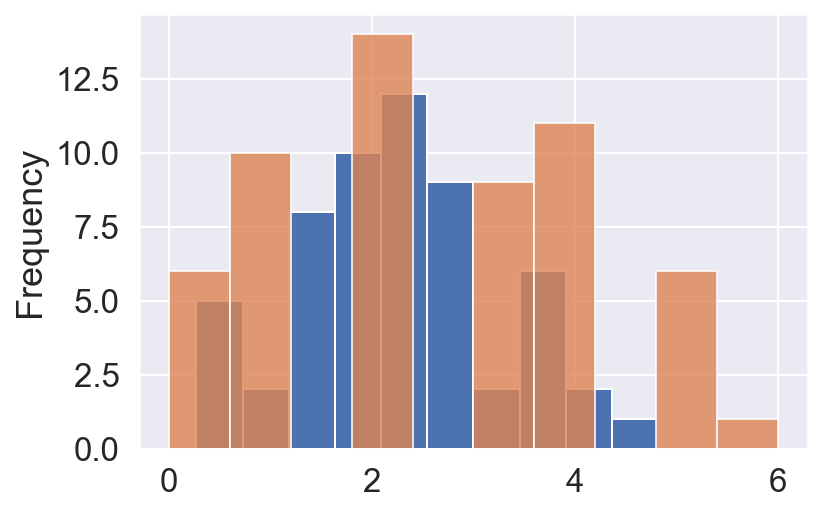

In [656]:
epl[epl['team1'] == 'Liverpool'].xg1.plot(kind='hist')
epl[epl['team1'] == 'Liverpool'].score1.plot(kind='hist', alpha=0.8)

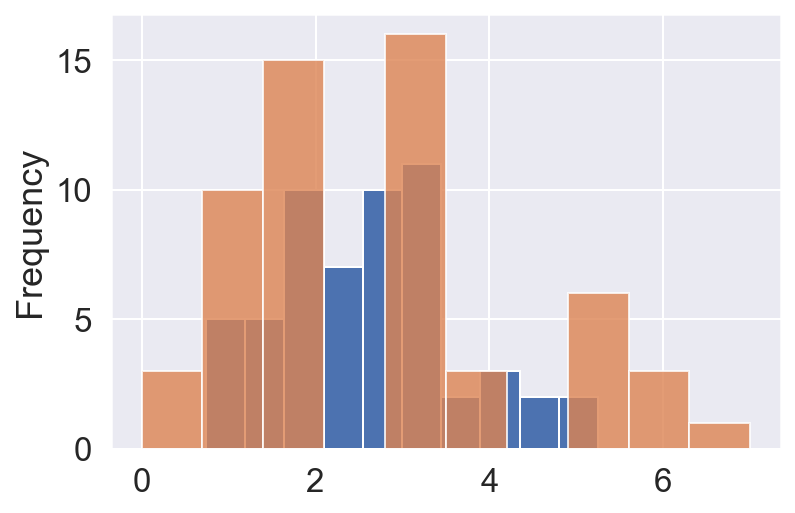

In [655]:
epl[epl['team1'] == 'ManCity'].xg1.plot(kind='hist')
epl[epl['team1'] == 'ManCity'].score1.plot(kind='hist', alpha=0.8)

### Football Odds DataFrames

These DataFrames will be the testing of the concept. Predicting the outcome of a football game with a great deal of certainty is an unlikely event. However, predicting the outcome of the game better than the bookies do is a possibility.

These dataframes show the bookies odds for the passed three seasons in the Premier League

In [7]:
football_data_2016 = pd.read_csv('csv/2016_2017.csv')
football_data_2017 = pd.read_csv('csv/2017_2018.csv')
football_data_2018 = pd.read_csv('csv/2018_2019.csv')

In [8]:
# Checking the shape, there should be 380 values based on a single season

football_data_2016.shape

(380, 65)

In [9]:
football_data_2017.shape

(380, 65)

In [10]:
# There are three less columns in this dataframe, probably going to need to drop these three so I can merge
# with the other two

football_data_2018.shape

(380, 62)

In [11]:
# How does it look

football_data_2018.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,...,1.79,17,-0.75,1.75,1.70,2.29,2.21,1.55,4.07,7.69
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,...,1.83,20,-0.75,2.20,2.13,1.80,1.75,1.88,3.61,4.70
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,...,1.87,22,-0.25,2.18,2.11,1.81,1.77,2.62,3.38,2.90
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,A,0,2,A,...,1.84,23,1.00,1.84,1.80,2.13,2.06,7.24,3.95,1.58
4,E0,11/08/2018,Newcastle,Tottenham,1,2,A,1,2,A,...,1.81,20,0.25,2.20,2.12,1.80,1.76,4.74,3.53,1.89


<b>It turns out that this dataframe has more variables than I thought it would. I'll use this one as my main dataframe and append the others to this.</b>

In [12]:
# a dirty list comprehension to see where the df's stop lining up

[n if n==i else np.nan for i,n in zip(football_data_2017.columns, football_data_2018.columns)]

['Div',
 'Date',
 'HomeTeam',
 'AwayTeam',
 'FTHG',
 'FTAG',
 'FTR',
 'HTHG',
 'HTAG',
 'HTR',
 'Referee',
 'HS',
 'AS',
 'HST',
 'AST',
 'HF',
 'AF',
 'HC',
 'AC',
 'HY',
 'AY',
 'HR',
 'AR',
 'B365H',
 'B365D',
 'B365A',
 'BWH',
 'BWD',
 'BWA',
 'IWH',
 'IWD',
 'IWA',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [13]:
# It looks like the missing columns occur just after 'IWA' - let's eyeball the three df's columns

In [14]:
football_data_2016.columns

Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
       'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD',
       'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA',
       'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'Bb1X2', 'BbMxH', 'BbAvH',
       'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5',
       'BbMx<2.5', 'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH',
       'BbMxAHA', 'BbAvAHA', 'PSCH', 'PSCD', 'PSCA'],
      dtype='object')

In [15]:
football_data_2017.columns

Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
       'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD',
       'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA',
       'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'Bb1X2', 'BbMxH', 'BbAvH',
       'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5',
       'BbMx<2.5', 'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH',
       'BbMxAHA', 'BbAvAHA', 'PSCH', 'PSCD', 'PSCA'],
      dtype='object')

In [16]:
football_data_2018.columns

Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
       'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD',
       'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA',
       'VCH', 'VCD', 'VCA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD',
       'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5',
       'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA',
       'PSCH', 'PSCD', 'PSCA'],
      dtype='object')

In [17]:
# Yes, just after IWA, 2016 and 2017 have three values that don't appear in 2018. I'll just drop those
# as I have enough betting companies anyway

In [18]:
football_data_2016.drop(columns=['LBH', 'LBD', 'LBA'], inplace=True)
football_data_2017.drop(columns=['LBH', 'LBD', 'LBA'], inplace=True)

In [19]:
# Create a list of the df's to merge them

frames = [football_data_2016, football_data_2017, football_data_2018]

In [20]:
# aaaaaaaand concat!
football_all = pd.concat(frames)

In [21]:
# Just checking....

football_all.shape

(1140, 62)

In [22]:
football_all.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,13/08/2016,Burnley,Swansea,0,1,A,0,0,D,...,1.61,32,-0.25,2.13,2.06,1.86,1.81,2.79,3.16,2.89
1,E0,13/08/2016,Crystal Palace,West Brom,0,1,A,0,0,D,...,1.52,33,-0.50,2.07,2.00,1.90,1.85,2.25,3.15,3.86
2,E0,13/08/2016,Everton,Tottenham,1,1,D,1,0,H,...,1.77,32,0.25,1.91,1.85,2.09,2.00,3.64,3.54,2.16
3,E0,13/08/2016,Hull,Leicester,2,1,H,1,0,H,...,1.67,31,0.25,2.35,2.26,2.03,1.67,4.68,3.50,1.92
4,E0,13/08/2016,Man City,Sunderland,2,1,H,1,0,H,...,2.48,34,-1.50,1.81,1.73,2.20,2.14,1.25,6.50,14.50


In [23]:
# convert date to datetime format

football_all['date'] = pd.to_datetime(football_all['Date'], format='%d/%m/%Y')

In [24]:
# make it the index

football_all.set_index('date', inplace=True, drop=True)

In [25]:
# give the index a name so I can sort it by index and home team

football_all.index.name = 'date'

In [26]:
football_all = football_all.sort_values(by = ['date', 'HomeTeam'], ascending = True)

In [27]:
football_all.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
date,,,,,,,,,,,,,,,,,,,,,
2016-08-13,E0,13/08/2016,Burnley,Swansea,0,1,A,0,0,D,...,1.61,32,-0.25,2.13,2.06,1.86,1.81,2.79,3.16,2.89
2016-08-13,E0,13/08/2016,Crystal Palace,West Brom,0,1,A,0,0,D,...,1.52,33,-0.50,2.07,2.00,1.90,1.85,2.25,3.15,3.86
2016-08-13,E0,13/08/2016,Everton,Tottenham,1,1,D,1,0,H,...,1.77,32,0.25,1.91,1.85,2.09,2.00,3.64,3.54,2.16
2016-08-13,E0,13/08/2016,Hull,Leicester,2,1,H,1,0,H,...,1.67,31,0.25,2.35,2.26,2.03,1.67,4.68,3.50,1.92
2016-08-13,E0,13/08/2016,Man City,Sunderland,2,1,H,1,0,H,...,2.48,34,-1.50,1.81,1.73,2.20,2.14,1.25,6.50,14.50


In [28]:
football_all.shape

(1140, 62)

In [29]:
# save it to csv 

football_all.to_csv('csv/football_all.csv')

In [30]:
pd.read_csv('csv/football_all.csv')

,date,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,2016-08-13,E0,13/08/2016,Burnley,Swansea,0,1,A,0,0,...,1.61,32,-0.25,2.13,2.06,1.86,1.81,2.79,3.16,2.89
1,2016-08-13,E0,13/08/2016,Crystal Palace,West Brom,0,1,A,0,0,...,1.52,33,-0.50,2.07,2.00,1.90,1.85,2.25,3.15,3.86
2,2016-08-13,E0,13/08/2016,Everton,Tottenham,1,1,D,1,0,...,1.77,32,0.25,1.91,1.85,2.09,2.00,3.64,3.54,2.16
3,2016-08-13,E0,13/08/2016,Hull,Leicester,2,1,H,1,0,...,1.67,31,0.25,2.35,2.26,2.03,1.67,4.68,3.50,1.92
4,2016-08-13,E0,13/08/2016,Man City,Sunderland,2,1,H,1,0,...,2.48,34,-1.50,1.81,1.73,2.20,2.14,1.25,6.50,14.50
5,2016-08-13,E0,13/08/2016,Middlesbrough,Stoke,1,1,D,1,0,...,1.53,32,-0.25,1.99,1.93,1.97,1.92,2.20,3.38,3.70
6,2016-08-13,E0,13/08/2016,Southampton,Watford,1,1,D,0,1,...,1.75,33,-0.75,2.16,2.07,1.89,1.80,1.80,3.83,4.91
7,2016-08-14,E0,14/08/2016,Arsenal,Liverpool,3,4,A,1,1,...,1.99,31,-0.50,2.41,2.31,1.81,1.64,2.80,3.44,2.68
8,2016-08-14,E0,14/08/2016,Bournemouth,Man United,1,3,A,0,1,...,1.76,33,0.75,1.80,1.76,2.17,2.11,5.40,3.65,1.78
9,2016-08-15,E0,15/08/2016,Chelsea,West Ham,2,1,H,0,0,...,2.01,33,-1.00,2.20,2.10,1.80,1.76,1.52,4.38,7.45


### Merging of Football Odds, EPL DataFrames and ELO DataFrames

Pretty much what it says on the tin... it's merging time

In [52]:
# Could get rid of the columns after the merge, it is just less messy doing it first
# I don't need these columns because they're features which were created by the author of the dataset
# and while they may help, I can't re-create them for any new data.
# I may include them later just to see if they add anything. 
# For Science

df = epl.drop(columns=['league_id', 'league', 'spi1', 'spi2', 'prob1',
       'prob2', 'probtie', 'proj_score1', 'proj_score2', 'importance1',
       'importance2','nsxg1', 'nsxg2',
       'adj_score1', 'adj_score2'])

In [53]:
# The only thing I really care about is the xg from this dataframe.

df.head()

,team1,team2,score1,score2,xg1,xg2
2016-08-13,Burnley,Swansea City,0.0,1.0,1.24,1.84
2016-08-13,Crystal Palace,WestBrom,0.0,1.0,1.11,0.68
2016-08-13,Everton,Tottenham Hotspur,1.0,1.0,0.73,1.11
2016-08-13,HullCity,Leicester City,2.0,1.0,0.85,2.77
2016-08-13,ManCity,Sunderland,2.0,1.0,2.14,1.25


In [54]:
football_all.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
date,,,,,,,,,,,,,,,,,,,,,
2016-08-13,E0,13/08/2016,Burnley,Swansea,0,1,A,0,0,D,...,1.61,32,-0.25,2.13,2.06,1.86,1.81,2.79,3.16,2.89
2016-08-13,E0,13/08/2016,Crystal Palace,West Brom,0,1,A,0,0,D,...,1.52,33,-0.50,2.07,2.00,1.90,1.85,2.25,3.15,3.86
2016-08-13,E0,13/08/2016,Everton,Tottenham,1,1,D,1,0,H,...,1.77,32,0.25,1.91,1.85,2.09,2.00,3.64,3.54,2.16
2016-08-13,E0,13/08/2016,Hull,Leicester,2,1,H,1,0,H,...,1.67,31,0.25,2.35,2.26,2.03,1.67,4.68,3.50,1.92
2016-08-13,E0,13/08/2016,Man City,Sunderland,2,1,H,1,0,H,...,2.48,34,-1.50,1.81,1.73,2.20,2.14,1.25,6.50,14.50


In [55]:
football_all.columns

Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
       'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD',
       'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA',
       'VCH', 'VCD', 'VCA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD',
       'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5',
       'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA',
       'PSCH', 'PSCD', 'PSCA'],
      dtype='object')

In [56]:
df2 = football_all[['FTR']]

In [57]:
df2.head()

,FTR
date,
2016-08-13,A
2016-08-13,A
2016-08-13,D
2016-08-13,H
2016-08-13,H


In [64]:
df4 = pd.concat([df,df2], axis=1)

In [66]:
df4.head()

,team1,team2,score1,score2,xg1,xg2,FTR
date,,,,,,,
2016-08-13,Burnley,Swansea City,0.0,1.0,1.24,1.84,A
2016-08-13,Crystal Palace,WestBrom,0.0,1.0,1.11,0.68,A
2016-08-13,Everton,Tottenham Hotspur,1.0,1.0,0.73,1.11,D
2016-08-13,HullCity,Leicester City,2.0,1.0,0.85,2.77,H
2016-08-13,ManCity,Sunderland,2.0,1.0,2.14,1.25,H


In [67]:
# Creating my target variables, changing from H for Home Win to a 0 for Home Win

df4['FTR'] = [0 if i=='H' else 1 if i=='A' else 2 for i in df4['FTR']]

In [68]:
df4.head()

,team1,team2,score1,score2,xg1,xg2,FTR
date,,,,,,,
2016-08-13,Burnley,Swansea City,0.0,1.0,1.24,1.84,1
2016-08-13,Crystal Palace,WestBrom,0.0,1.0,1.11,0.68,1
2016-08-13,Everton,Tottenham Hotspur,1.0,1.0,0.73,1.11,2
2016-08-13,HullCity,Leicester City,2.0,1.0,0.85,2.77,0
2016-08-13,ManCity,Sunderland,2.0,1.0,2.14,1.25,0


Below I am combining columns from the viewpoint of the home team. The columns relate to Half Time Home Goals and Half Time Away Goals and Home Shots on Target and Away Shots on Target. By subtracting the Away value from the Home value I am reducing the number of input variables. Also, I get a chance to rename the columns

In [69]:
# First Season

In [70]:
df4[(df4.index <= '2017-06') & (df4.index >= '2016-08')].shape # First Whole Season

(380, 7)

In [71]:
df11 = df4[(df4.index < '2016-12') & (df4.index >= '2016-08')]  #First third of First Season
df11['season_period'] = [0 for i in df11.index]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [72]:
df21 = df4[(df4.index < '2017-04') & (df4.index >= '2016-12')] # Second third of First Season
df21['season_period'] = [1 for i in df21.index]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [73]:
df31 = df4[(df4.index < '2017-07') & (df4.index >= '2017-04')] # Final third of First Season
df31['season_period'] = [2 for i in df31.index]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [74]:
# Second Season

In [75]:
df4[(df4.index <= '2018-06') & (df4.index >= '2017-08')].shape # Second Whole Season

(380, 7)

In [76]:
df12 = df4[(df4.index < '2017-12') & (df4.index >= '2017-08')]  #First third of Second Season
df12['season_period'] = [0 for i in df12.index]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [77]:
df22 = df4[(df4.index < '2018-04') & (df4.index >= '2017-12')] # Second third of Second Season
df22['season_period'] = [1 for i in df22.index]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [78]:
df32 = df4[(df4.index < '2018-07') & (df4.index >= '2018-04')] # Final third of Second Season
df32['season_period'] = [2 for i in df32.index]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [79]:
# Third Season

In [80]:
df4[(df4.index <= '2019-06') & (df4.index >= '2018-08')].shape# Third Whole Season

(380, 7)

In [81]:
df13 = df4[(df4.index < '2018-12') & (df4.index >= '2018-08')]  #First third of Third Season
df13['season_period'] = [0 for i in df13.index]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [82]:
df23 = df4[(df4.index < '2019-04') & (df4.index >= '2018-12')] # Second third of Third Season
df23['season_period'] = [1 for i in df23.index]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [83]:
df33 = df4[(df4.index < '2019-07') & (df4.index >= '2019-04')] # Final third of Third Season
df33['season_period'] = [2 for i in df33.index]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [84]:
df4.shape

(1140, 7)

In [85]:
frames = [df11, df21, df31, df12, df22, df32, df13, df23, df33]


In [86]:
df5 = pd.concat(frames)

In [87]:
df5.shape

(1140, 8)

In [88]:
df5 = df5.sort_values(by = ['date', 'team1'], ascending = True)

In [89]:
# Run the below to generate a key for all the home teams to merge with Home Elo's

df5['key'] = [str(i)+n[:5] for i,n in zip(df5.index, df5['team1'])]

In [90]:
df5 = pd.merge(left=df5, right=all_elo, left_on='key', right_on='key', how='left')

NameError: name 'all_elo' is not defined

In [ ]:
df5.shape

In [ ]:
df5['home_elo'] = [i for i in df5['Elo']]

In [ ]:
df5.drop(columns=['key', 'Club', 'Elo'], inplace=True)

In [ ]:
df5.columns

In [ ]:
# Lost index during merge, need to recreate it
df5['date'] = [i for i in df4.index]

In [ ]:
df5.head(10)

In [ ]:
df5.set_index('date', inplace=True)

In [ ]:
# change key so that I can add away elo, too

df5['key'] = [str(i)+n[:5] for i,n in zip(df5.index, df5['team2'])]

In [ ]:
df5 = pd.merge(left=df5, right=all_elo, left_on='key', right_on='key', how='left')

In [ ]:
df5.shape

In [ ]:
df5['away_elo'] = [i for i in df5['Elo']]

In [ ]:
df5.drop(columns=['key', 'Club', 'Elo'], inplace=True)

In [ ]:
df5.tail(10)

In [ ]:
df5.home_elo.isnull().sum()

In [ ]:
teams = list(df5.team1.unique())

In [ ]:
df5.set_index(df4.index, inplace=True)

In [ ]:
df5['score1'] = df['score1']
df5['score2'] = df['score2']

In [ ]:
df5['FTR_alpha'] = football_all['FTR']

In [ ]:
df5.head()

In [ ]:
# creating columns for form and average xg

In [ ]:
new_df = pd.DataFrame()

for team in teams:
    
    tester = df5[df5['team1'] == team] # create a new dataframe sorting by home team only

    xg1_tracker = [1,2,3,4,5] # add 5 numbers because the length of the column is five longer than I have data for
    xg2_tracker = [1,2,3,4,5]
    
    gd_tracker = [1,2,3,4,5]
    
    game_hist = [[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5]]
    

    for i in range(5,len(tester['xg1'])): # for each row in new dataframe

        xg1_adder = 0
        xg2_adder = 0
        gd1_adder = 0
        gd2_adder = 0
        
        game = 0
        history_tracker = []
        
        for x in range(i-5,i):
            
            xg1_adder += tester['xg1'][x] # add up the xg for the last five games
            xg2_adder += tester['xg2'][x]
            history_tracker.append(tester['FTR_alpha'][x])
            gd1_adder += tester['score1'][x]
            gd2_adder += tester['score2'][x]
            
            
            
        xg1_tracker.append(xg1_adder/5) # append the xg to a list dividing by 5 to give the avg
        xg2_tracker.append(xg2_adder/5) 
        
        gd_tracker.append((gd1_adder - gd2_adder)/5)
        
        game_hist.append(history_tracker)

        
    tester['xg1_5g_avg'] = [i for i in xg1_tracker] # create a column with the avg xg for the last 5 games
    tester['xg2_5g_avg'] = [i for i in xg2_tracker]
    
    tester['gd_5g_avg'] = [i for i in gd_tracker] # goal diff avg over last 5 games
    
   
    tester['game1'] = [i[0] for i in game_hist]
    tester['game2'] = [i[1] for i in game_hist]
    tester['game3'] = [i[2] for i in game_hist]    
    tester['game4'] = [i[3] for i in game_hist]
    tester['game5'] = [i[4] for i in game_hist]
    
    tester = tester.iloc[5:] # ignore the first 5 rows because I don't have historical data for them
    
    new_df = pd.concat([new_df, tester]) # append updated dataframe to new_df


In [ ]:
new_df.tail()

In [ ]:
new_df.head()

In [ ]:
no_club_no_xg = new_df.copy()

In [ ]:
no_club_no_xg['elo_diff'] = no_club_no_xg['home_elo'] - no_club_no_xg['away_elo']

In [ ]:
no_club_no_xg.reset_index(inplace=True)

In [ ]:
no_club_no_xg.columns

In [ ]:
# Remove the below and run again if putting them in order fucks them up

In [ ]:
no_club_no_xg = no_club_no_xg.sort_values(by = ['date', 'team1'], ascending = True)

In [ ]:
no_club_no_xg.drop(columns=['team1', 'team2', 'xg1', 'xg2','yellow_cards', 
                            'total_shots', 'shots_on_target', 'free_kicks', 'corners', 'red_cards', 'home_elo',
                            'away_elo', 'date', 'A Marriner', 'A Taylor', 'C Kavanagh',
       'C Pawson', 'D Coote', 'G Scott', 'J Moss', 'K Friend', 'L Mason',
       'L Probert', 'M Atkinson', 'M Clattenburg', 'M Dean', 'M Jones',
       'M Oliver', 'N Swarbrick', 'P Tierney', 'R East', 'R Madley',
       'S Attwell', 'S Hooper', 'l Mason', 'half_time_gd', 'score1', 'score2', 'FTR_alpha'], inplace=True)

In [ ]:
no_club_no_xg['FTR v HTR'] = no_club_no_xg['FTR'] - no_club_no_xg['HTR']

In [ ]:
no_club_no_xg['FTR v HTR'].value_counts(normalize=True)

In [ ]:
# 61% of the time, a match ends the way it is at half time.

In [ ]:
no_club_no_xg.drop(columns=['HTR', 'FTR v HTR'], inplace=True)

In [ ]:
no_club_no_xg = pd.get_dummies(no_club_no_xg, drop_first=True)

In [ ]:
new_df.to_csv('new_df.csv')

In [ ]:
no_club_no_xg.to_csv('no_club.csv')

# Modelling Time!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
modelling_df = pd.read_csv('csv/no_club.csv', index_col=0)

In [4]:
modelling_df.head()

,FTR,season_period,xg1_5g_avg,xg2_5g_avg,gd_5g_avg,elo_diff,game1_D,game1_H,game2_D,game2_H,game3_D,game3_H,game4_D,game4_H,game5_D,game5_H
0,0,0,0.650,1.306,0.4,-90.930786,0,0,0,1,1,0,0,1,0,0
340,1,0,1.078,1.228,1.0,30.798828,0,0,0,1,0,1,0,1,1,0
1,0,0,0.596,1.138,0.8,12.096313,0,1,1,0,0,1,0,0,0,1
392,0,0,2.090,0.756,2.0,110.588257,0,1,0,1,0,0,0,1,0,1
170,2,0,2.468,0.630,1.4,280.346558,0,1,0,1,0,1,1,0,1,0


In [5]:
y = modelling_df.pop('FTR')

In [6]:
y.value_counts(normalize=True)

0    0.483168
1    0.300000
2    0.216832
Name: FTR, dtype: float64

In [7]:
# Getting that sweet baseline

In [8]:
X = modelling_df.copy()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [10]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=(X_train.columns))

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
X_train.columns

Index(['season_period', 'xg1_5g_avg', 'xg2_5g_avg', 'gd_5g_avg', 'elo_diff',
       'game1_D', 'game1_H', 'game2_D', 'game2_H', 'game3_D', 'game3_H',
       'game4_D', 'game4_H', 'game5_D', 'game5_H'],
      dtype='object')

In [12]:
model = LogisticRegressionCV(solver='liblinear', multi_class='ovr', cv=5)

model.fit(X_train, y_train)
yhat_test = model.predict(X_test)
log_reg_test = model.score(X_test, y_test)
log_reg_cv = model.score(X_train, y_train)
print(log_reg_test)
print(log_reg_cv)

0.5396039603960396
0.5346534653465347


In [13]:
pd.DataFrame(confusion_matrix(y_test, yhat_test))

,0,1,2
0,66,6,26
1,15,21,24
2,15,7,22


In [14]:
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       0.69      0.67      0.68        98
           1       0.62      0.35      0.45        60
           2       0.31      0.50      0.38        44

   micro avg       0.54      0.54      0.54       202
   macro avg       0.54      0.51      0.50       202
weighted avg       0.58      0.54      0.55       202



In [15]:
# Not great at predicting draws... hmm...

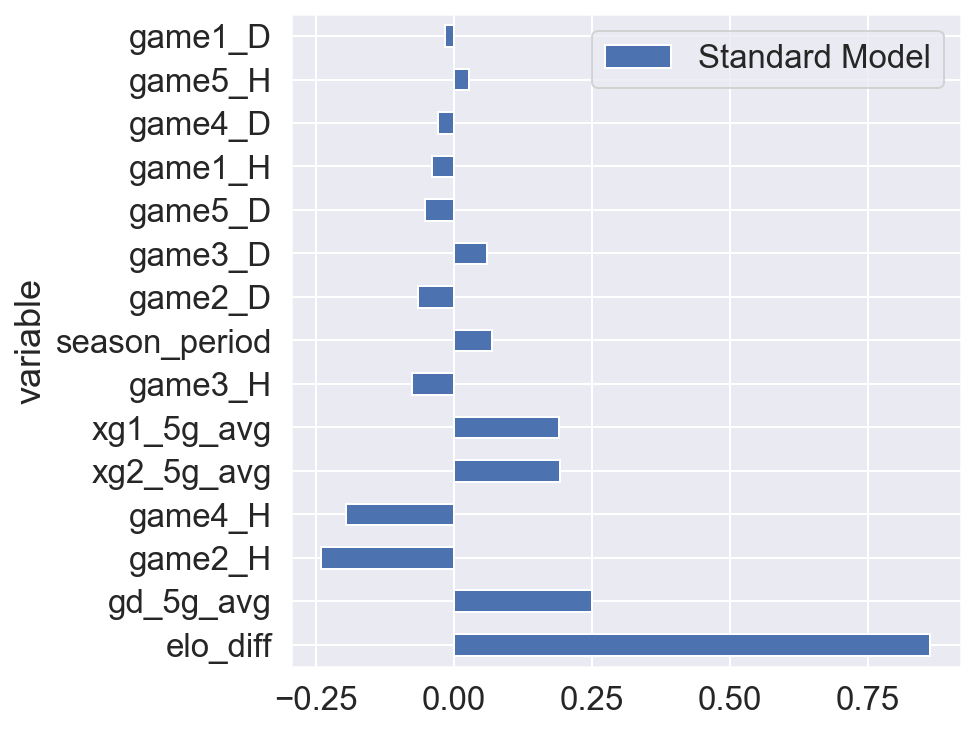

In [16]:
coefs_vars_model = pd.DataFrame({
    'coef': model.coef_[0],
    'variable': X.columns,
    'abscoef': np.abs(model.coef_[0])
})
coefs_vars_model.sort_values('abscoef', ascending=False, inplace=True)
coefs_vars_model.plot(kind='barh', x='variable', y='coef',
                      color='b', figsize=(6, 6), label='Standard Model')
plt.show()

In [17]:
lr_ridge = LogisticRegressionCV(
    penalty='l2', Cs=100, cv=5, solver='liblinear')
lr_ridge.fit(X_train, y_train)


ridge_test = lr_ridge.score(X_test, y_test)
ridge_cv = lr_ridge.score(X_train, y_train)

print(lr_ridge.C_)
print(ridge_test)
print(ridge_cv)


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[2.05651231e-01 1.83073828e-02 1.20450354e-04]
0.5346534653465347
0.5346534653465347


In [18]:
yhat_ridge = lr_ridge.predict(X_test)
yhat_pp_ridge = lr_ridge.predict_proba(X_test)

In [19]:
pd.DataFrame(confusion_matrix(y_test, yhat_ridge))

,0,1,2
0,66,5,27
1,15,22,23
2,18,6,20


In [20]:
print(classification_report(y_test, yhat_ridge))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        98
           1       0.67      0.37      0.47        60
           2       0.29      0.45      0.35        44

   micro avg       0.53      0.53      0.53       202
   macro avg       0.54      0.50      0.50       202
weighted avg       0.58      0.53      0.54       202



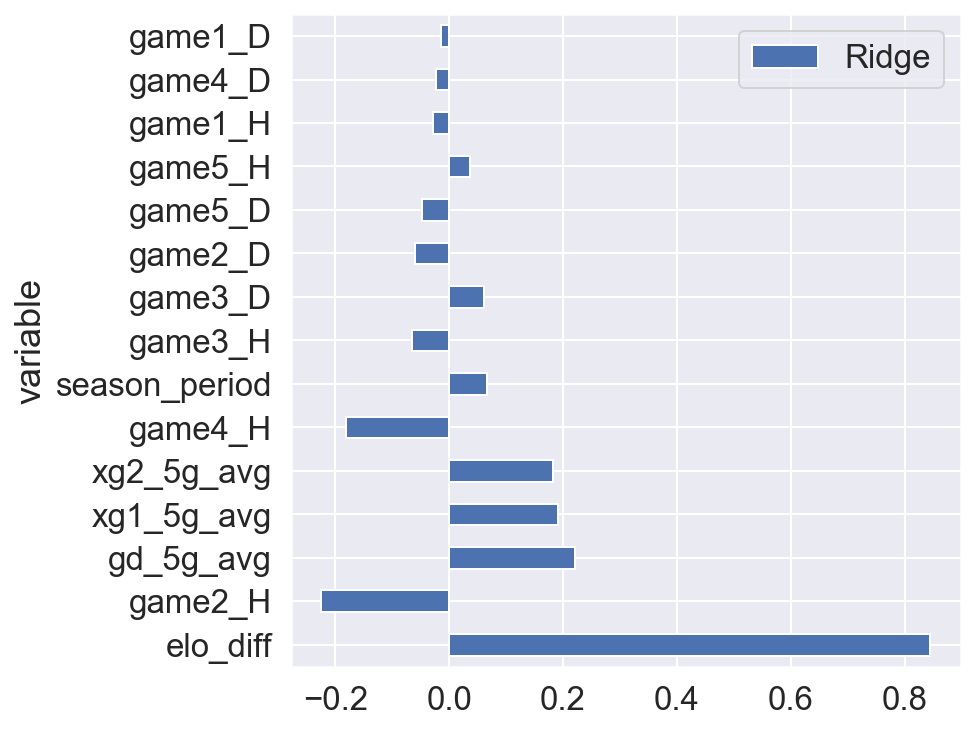

In [21]:
coefs_vars_ridge = pd.DataFrame({
    'coef': lr_ridge.coef_[0],
    'variable': X.columns,
    'abscoef': np.abs(lr_ridge.coef_[0])
})
coefs_vars_ridge.sort_values('abscoef', ascending=False, inplace=True)
coefs_vars_ridge.plot(kind='barh', x='variable', y='coef',
                      color='b', figsize=(6, 6), label='Ridge')
plt.show()

<b>5 game gd as well, and dummify the game columns, add game number to each game from 1 to 38</b>

In [22]:
from sklearn.model_selection import GridSearchCV

In [33]:
griddy = LogisticRegression()

In [34]:
griddy.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)>

In [37]:
params = {'penalty': ['l1', 'l2'],
                   'solver': ['liblinear'],
                   'C': [1,10,50,100]}

In [38]:
model_gs = GridSearchCV(griddy, params, cv=5, n_jobs=2, verbose=1)

In [39]:
model_gs.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    1.5s finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'C': [1, 10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [40]:
model_gs.best_params_

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

In [41]:
model_gs.best_score_

0.5655940594059405

In [42]:
lasso_test = model_gs.score(X_test, y_test)

In [43]:
lasso_cv = model_gs.score(X_train, y_train)

In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

folds = 5
max_neighbors = 100



# plot test accuracy by number of neighbors:
test_acc = []
for i in range(1, int(max_neighbors)):
    knn = KNeighborsClassifier(n_neighbors=i)
    test_acc.append(np.mean(cross_val_score(knn, X_train, y_train, cv=folds)))

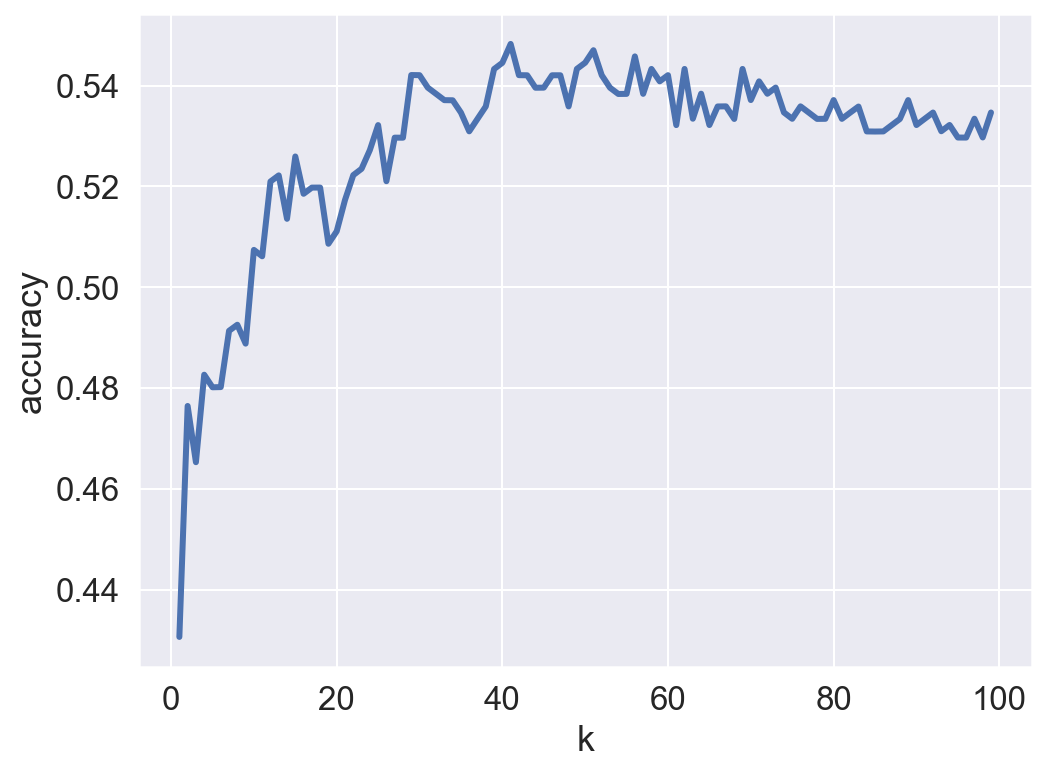

In [45]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1, int(max_neighbors)), test_acc, lw=3.)
ax.set_xlabel('k')
ax.set_ylabel('accuracy')
plt.show()

In [46]:
knn = KNeighborsClassifier(n_neighbors=38)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))
print(max(test_acc))


0.5247524752475248
0.5482478337550801


In [47]:
knn_test = knn.score(X_test, y_test)
knn_cv = cross_val_score(knn, X_train, y_train, cv=5).mean()

In [48]:
from sklearn import svm, linear_model, datasets

In [149]:
clf = svm.SVC(gamma='scale', probability=True)
clf_cv = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()
clf_test = clf.fit(X_train, y_train).score(X_test, y_test)

In [150]:
clf.get_params

<bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>

In [44]:
from sklearn.model_selection import GridSearchCV


gamma_range = np.logspace(-5, 2, 20)
c = np.linspace(1,100,10)
param_grid = dict(gamma=gamma_range, C=c, kernel=['rbf'])

clf_grid = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy',
                    verbose=True, return_train_score=True, iid=False, n_jobs=2)
clf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    5.2s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   25.4s
[Parallel(n_jobs=2)]: Done 888 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=False, n_jobs=2,
       param_grid={'gamma': array([1.00000e-05, 2.33572e-05, 5.45559e-05, 1.27427e-04, 2.97635e-04,
       6.95193e-04, 1.62378e-03, 3.79269e-03, 8.85867e-03, 2.06914e-02,
       4.83293e-02, 1.12884e-01, 2.63665e-01, 6.15848e-01, 1.43845e+00,
       3.35982e+00, 7.84760e+00, 1.83298e+01, 4.28133e+01, 1.00000e+02]), 'C': array([  1.,  12.,  23.,  34.,  45.,  56.,  67.,  78.,  89., 100.]), 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [202]:
clf_grid_results = pd.DataFrame(clf_grid.cv_results_)
clf_grid_results['gamma'] = [x['gamma'] for x in clf_grid_results.params.values]
clf_grid_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,gamma
0,0.116307,0.024544,0.010885,0.011409,1,1e-05,rbf,"{'C': 1.0, 'gamma': 1e-05, 'kernel': 'rbf'}",0.481481,0.481481,0.481481,0.484472,0.484472,0.482678,0.001465,86,0.482972,0.482972,0.482972,0.482226,0.482226,0.482674,0.000366,0.000010
1,0.099361,0.018230,0.003676,0.000605,1,2.33572e-05,rbf,"{'C': 1.0, 'gamma': 2.3357214690901213e-05, 'k...",0.481481,0.481481,0.481481,0.484472,0.484472,0.482678,0.001465,86,0.482972,0.482972,0.482972,0.482226,0.482226,0.482674,0.000366,0.000023
2,0.098070,0.015344,0.004786,0.001315,1,5.45559e-05,rbf,"{'C': 1.0, 'gamma': 5.4555947811685143e-05, 'k...",0.481481,0.481481,0.481481,0.484472,0.484472,0.482678,0.001465,86,0.482972,0.482972,0.482972,0.482226,0.482226,0.482674,0.000366,0.000055
3,0.077568,0.011633,0.002927,0.000129,1,0.000127427,rbf,"{'C': 1.0, 'gamma': 0.00012742749857031334, 'k...",0.481481,0.481481,0.481481,0.484472,0.484472,0.482678,0.001465,86,0.482972,0.482972,0.482972,0.482226,0.482226,0.482674,0.000366,0.000127
4,0.069575,0.000659,0.002842,0.000068,1,0.000297635,rbf,"{'C': 1.0, 'gamma': 0.00029763514416313193, 'k...",0.481481,0.481481,0.481481,0.484472,0.484472,0.482678,0.001465,86,0.482972,0.482972,0.482972,0.482226,0.482226,0.482674,0.000366,0.000298


In [203]:
clf_grid.best_params_

{'C': 34.0, 'gamma': 0.00029763514416313193, 'kernel': 'rbf'}

In [48]:

clf_grid_cv = clf_grid.score(X_train, y_train)
clf_grid_test = clf_grid.score(X_test, y_test)

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [52]:

DT = DecisionTreeClassifier()
bc = BaggingClassifier(base_estimator=DT,
                       n_estimators=50,
                       max_features=0.5,
                       max_samples=0.5,
                       oob_score=True)


bc.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=0.5, n_estimators=50, n_jobs=None, oob_score=True,
         random_state=None, verbose=0, warm_start=False)

In [53]:
bc_cv = cross_val_score(bc, X_train, y_train, cv=5).mean()

In [54]:
bc_test = bc.score(X_test, y_test)

In [55]:
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import datasets
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

In [65]:
gradboo_model = GradientBoostingClassifier(n_estimators=1000,
                                   criterion='mse',
                                   loss='deviance',
                                   max_depth=3,
                                   #learning_rate=1.0,
                                   random_state=1,
                                   min_samples_split=4)
gradboo_model.fit(X_train, y_train)


gradboo_cv = cross_val_score(gradboo_model, X_train, y_train, cv=5).mean()
gradboo_test = gradboo_model.score(X_test, y_test)

0    0.500000
1    0.589109
2    0.599010
3    0.599010
4    0.594059
dtype: float64


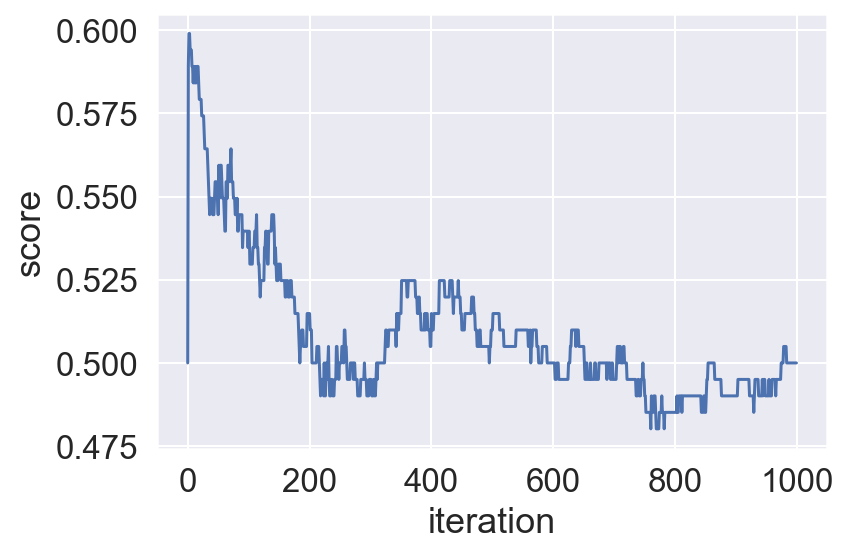

In [66]:
scores = pd.DataFrame(gradboo_model.staged_predict(X_test)).T.apply(
    lambda x: accuracy_score(y_test, x), axis=0)
print(scores.head())
scores.plot()
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [67]:
gradboo_model.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='mse', init=None, learning_rate=0.1,
              loss='deviance', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=4, min_weight_fraction_leaf=0.0,
              n_estimators=1000, n_iter_no_change=None, presort='auto',
              random_state=1, subsample=1.0, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False)>

In [68]:
params = {'n_estimators':[100,10000,100],
          'max_depth':[3,4,5],
          'min_samples_split':[2,4,6]
          }

grad_grid = GridSearchCV(gradboo_model, params, cv=5, n_jobs=2, verbose=1)

In [69]:
grad_grid.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 135 out of 135 | elapsed:  5.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='mse', init=None, learning_rate=0.1,
              loss='deviance', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=...te=1, subsample=1.0, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'n_estimators': [100, 10000, 100], 'max_depth': [3, 4, 5], 'min_samples_split': [2, 4, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [70]:
grad_grid.best_params_

{'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 100}

In [71]:
grad_grid_cv = grad_grid.score(X_train, y_train)

In [72]:
grad_grid_test = grad_grid.score(X_test, y_test)

### Comparing Predictions to Bookies

In [73]:
lr_preds = pd.DataFrame(model.predict_proba(X), columns=['HomeWin', 'AwayWin', 'Draw'])

In [74]:
knn_preds = pd.DataFrame(knn.predict_proba(X), columns=['HomeWin', 'AwayWin', 'Draw'])

In [75]:
ridge_preds = pd.DataFrame(lr_ridge.predict_proba(X), columns=['HomeWin', 'AwayWin', 'Draw'])

In [76]:
gs_preds = pd.DataFrame(model_gs.predict_proba(X), columns=['HomeWin', 'AwayWin', 'Draw'])

In [151]:
svc_preds = pd.DataFrame(clf.predict_proba(X), columns=['HomeWin', 'AwayWin', 'Draw'])

In [79]:
bc_preds = pd.DataFrame(bc.predict_proba(X), columns=['HomeWin', 'AwayWin', 'Draw'])

In [80]:
gradboo_preds = pd.DataFrame(gradboo_model.predict_proba(X), columns=['HomeWin', 'AwayWin', 'Draw'])

In [81]:
gradgrid_preds = pd.DataFrame(grad_grid.predict_proba(X), columns=['HomeWin', 'AwayWin', 'Draw'])

In [167]:
orig_df = pd.read_csv('new_df.csv')

In [168]:
orig_df = pd.concat([orig_df, bc_preds], axis=1)

In [169]:
orig_df['HomeWin'] = [round(i, 3) for i in orig_df['HomeWin']]
orig_df['AwayWin'] = [round(i, 3) for i in orig_df['AwayWin']]
orig_df['Draw'] = [round(i, 3) for i in orig_df['Draw']]

In [160]:
# looping tester

model_preddies = [lr_preds, ridge_preds, gs_preds, knn_preds, svc_preds, bc_preds, gradboo_preds
                 ]

results = []

for mod in model_preddies:
    
    orig_df = pd.read_csv('new_df.csv')
    orig_df = pd.concat([orig_df, mod], axis=1)

    checkywecky = []
    for i in range(len(orig_df)):
        checkywecky.append(np.argmax(orig_df[['HomeWin', 'Draw', 'AwayWin']].iloc[i]))

    results.append(sum([1 if j==n else 0 for j,n in 
         zip([0 if i=='HomeWin' else 1 if i=='AwayWin' else 2 for i in checkywecky], 
             orig_df['FTR'])])/1010)
    

In [210]:
testses = [log_reg_test, ridge_test, lasso_test, knn_test, clf_test, bc_cv, gradboo_cv, grad]
cvses = [log_reg_cv, ridge_cv, lasso_cv, knn_cv, clf_cv, bc_test, gradboo_test]

In [161]:
models_df = pd.DataFrame([results,
               [log_reg_test, ridge_test, lasso_test, knn_test, clf_test, bc_cv, gradboo_cv],
               [log_reg_cv, ridge_cv, lasso_cv, knn_cv, clf_cv, bc_test, gradboo_test]], 
                         columns=['LogReg', 'Ridge', 'Lasso', 'KNN','SVC', 
                             'BaggClass', 'GradBoost'],
            index=['money_maker', 'test', 'cv']).T.sort_values(by='money_maker', ascending=False)

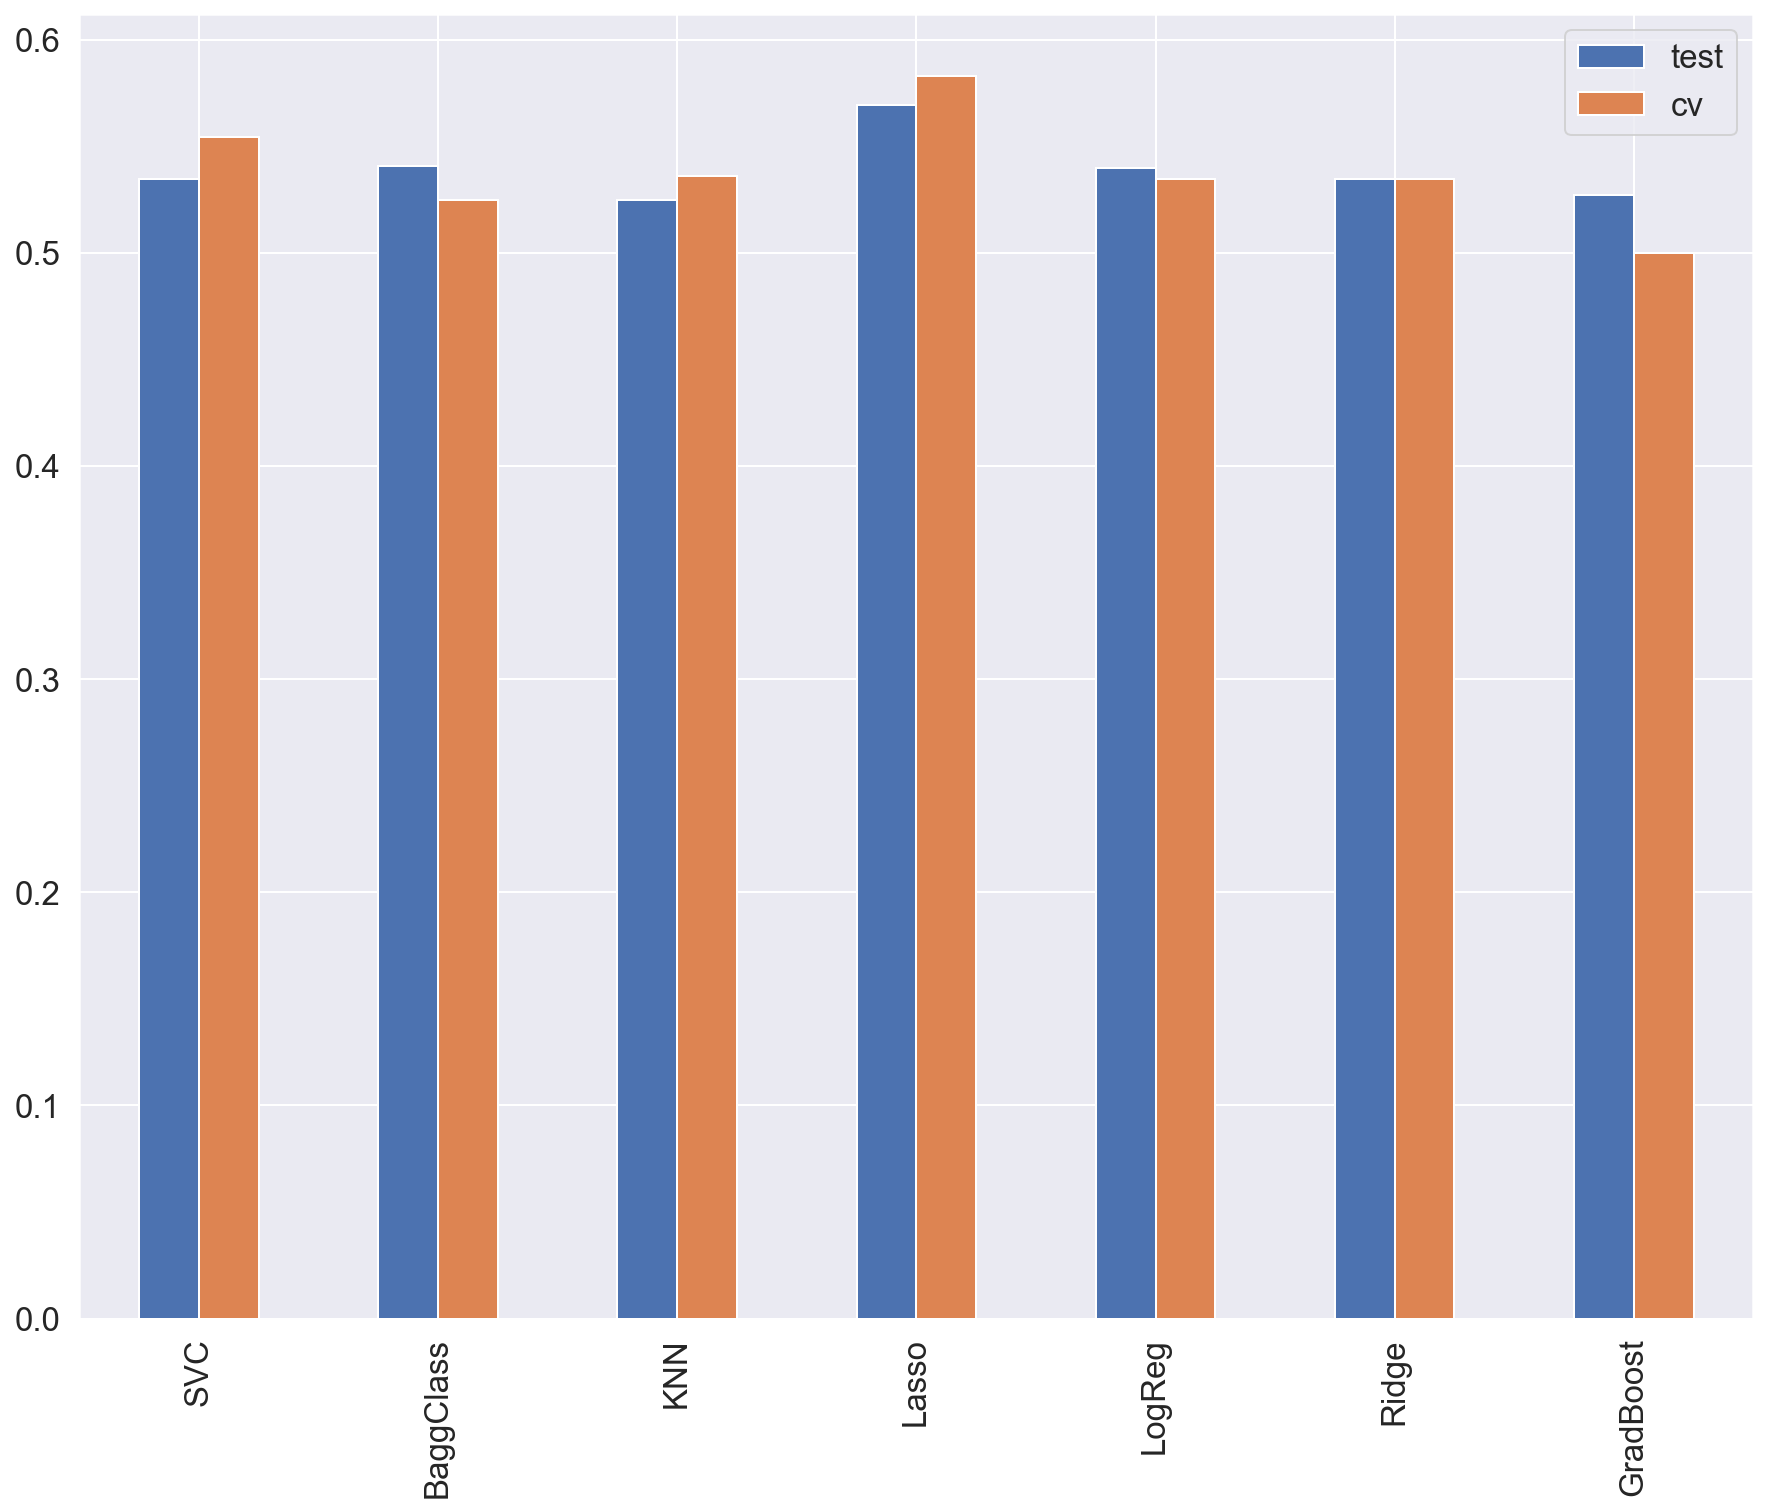

In [162]:
from matplotlib import pyplot as plt
models_df.drop(columns=['money_maker']).plot(kind='bar', figsize=[15,12])
plt.savefig('model.png', bbox_inches='tight')

In [164]:
models_df.sort_values(by='money_maker', ascending=False)

,money_maker,test,cv
SVC,0.477228,0.534653,0.554428
BaggClass,0.439604,0.540886,0.524752
KNN,0.415842,0.524752,0.535864
Lasso,0.413861,0.569307,0.582921
LogReg,0.412871,0.539604,0.534653
Ridge,0.412871,0.534653,0.534653
GradBoost,0.402970,0.527214,0.500000


In [118]:
clf_test

0.5445544554455446

In [170]:
orig_df.to_csv('with_probs.csv')

### Checking La Liga.. how accurate are the bookies?

In [ ]:
checkywecky = []
    for i in range(len(orig_df)):
        checkywecky.append(np.argmax(orig_df[['HomeWin', 'Draw', 'AwayWin']].iloc[i]))

    sum([1 if j==n else 0 for j,n in 
         zip([0 if i=='HomeWin' else 1 if i=='AwayWin' else 2 for i in checkywecky], 
             orig_df['FTR'])])/1010

# Betting Comparison

In [97]:
foot_odds = pd.read_csv('football_all.csv')

In [98]:
only_odds = foot_odds.drop(columns=['Div','FTHG', 'FTAG', 'HTHG',
       'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
       'AC', 'HY', 'AY', 'HR', 'AR', 'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5',
       'BbAv<2.5', 'Bb1X2', 'BbOU', 'BbAH', 'BbAHh', 'BbAH', 'BbMxAHH', 
       'BbAvAHH', 'BbMxAHA', 'BbAvAHA', 'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD',
       'BbMxA', 'BbAvA'])

In [99]:
only_odds.head()

,date,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,BWD,...,PSA,WHH,WHD,WHA,VCH,VCD,VCA,PSCH,PSCD,PSCA
0,2016-08-13,13/08/2016,Burnley,Swansea,A,2.40,3.3,3.25,2.45,3.1,...,3.19,2.50,3.20,2.90,2.50,3.2,3.25,2.79,3.16,2.89
1,2016-08-13,13/08/2016,Crystal Palace,West Brom,A,2.00,3.3,4.50,2.00,3.2,...,4.32,2.05,3.10,4.00,2.00,3.3,4.40,2.25,3.15,3.86
2,2016-08-13,13/08/2016,Everton,Tottenham,D,3.20,3.4,2.40,2.95,3.2,...,2.37,3.10,3.10,2.40,3.25,3.4,2.38,3.64,3.54,2.16
3,2016-08-13,13/08/2016,Hull,Leicester,H,4.50,3.6,1.91,4.33,3.4,...,1.95,4.20,3.25,1.95,4.40,3.5,1.95,4.68,3.50,1.92
4,2016-08-13,13/08/2016,Man City,Sunderland,H,1.25,6.5,15.00,1.22,6.0,...,13.15,1.25,5.50,13.00,1.25,6.5,15.00,1.25,6.50,14.50


In [100]:
only_odds.shape

(1140, 26)

In [101]:
only_odds.columns

Index(['date', 'Date', 'HomeTeam', 'AwayTeam', 'FTR', 'B365H', 'B365D',
       'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA',
       'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'PSCH', 'PSCD', 'PSCA'],
      dtype='object')

In [102]:
# convert from decimal to probabilities

here_we_go = ['B365H', 'B365D', 'B365A', 'BWH',
       'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD',
       'WHA', 'VCH', 'VCD', 'VCA', 'PSCH', 'PSCD', 'PSCA']

for header in here_we_go:
    only_odds[header] = [1/i for i in only_odds[header]]

In [103]:
only_odds.head()

,date,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,BWD,...,PSA,WHH,WHD,WHA,VCH,VCD,VCA,PSCH,PSCD,PSCA
0,2016-08-13,13/08/2016,Burnley,Swansea,A,0.416667,0.303030,0.307692,0.408163,0.322581,...,0.313480,0.400000,0.312500,0.344828,0.400000,0.312500,0.307692,0.358423,0.316456,0.346021
1,2016-08-13,13/08/2016,Crystal Palace,West Brom,A,0.500000,0.303030,0.222222,0.500000,0.312500,...,0.231481,0.487805,0.322581,0.250000,0.500000,0.303030,0.227273,0.444444,0.317460,0.259067
2,2016-08-13,13/08/2016,Everton,Tottenham,D,0.312500,0.294118,0.416667,0.338983,0.312500,...,0.421941,0.322581,0.322581,0.416667,0.307692,0.294118,0.420168,0.274725,0.282486,0.462963
3,2016-08-13,13/08/2016,Hull,Leicester,H,0.222222,0.277778,0.523560,0.230947,0.294118,...,0.512821,0.238095,0.307692,0.512821,0.227273,0.285714,0.512821,0.213675,0.285714,0.520833
4,2016-08-13,13/08/2016,Man City,Sunderland,H,0.800000,0.153846,0.066667,0.819672,0.166667,...,0.076046,0.800000,0.181818,0.076923,0.800000,0.153846,0.066667,0.800000,0.153846,0.068966


In [104]:
only_odds['FTR'] = [0 if i=='H' else 1 if i=='A' else 2 for i in only_odds['FTR']]

In [105]:
only_odds.tail()

,date,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,BWD,...,PSA,WHH,WHD,WHA,VCH,VCD,VCA,PSCH,PSCD,PSCA
1135,2019-05-12,12/05/2019,Liverpool,Wolves,0,0.769231,0.166667,0.090909,0.769231,0.173913,...,0.094877,0.775194,0.181818,0.090909,0.769231,0.173913,0.086957,0.757576,0.169779,0.105485
1136,2019-05-12,12/05/2019,Man United,Cardiff,1,0.781250,0.153846,0.090909,0.800000,0.160000,...,0.097943,0.800000,0.153846,0.100000,0.775194,0.160000,0.090909,0.769231,0.165017,0.102987
1137,2019-05-12,12/05/2019,Southampton,Huddersfield,2,0.694444,0.210526,0.117647,0.704225,0.210526,...,0.131234,0.714286,0.210526,0.125000,0.714286,0.208333,0.117647,0.729927,0.186567,0.117786
1138,2019-05-12,12/05/2019,Tottenham,Everton,2,0.454545,0.285714,0.285714,0.476190,0.285714,...,0.274725,0.476190,0.285714,0.285714,0.476190,0.285714,0.270270,0.523560,0.262467,0.240964
1139,2019-05-12,12/05/2019,Watford,West Ham,1,0.444444,0.266667,0.312500,0.454545,0.270270,...,0.311526,0.454545,0.270270,0.322581,0.454545,0.266667,0.307692,0.473934,0.259067,0.293255


In [106]:
only_odds.drop(columns=['Date'], inplace=True)

In [107]:
only_odds['HomeTeam'] = ['ManUtd' if i=='Man United' else i for i in only_odds['HomeTeam']]
only_odds['HomeTeam'] = ['ManCity' if i=='Man City' else i for i in only_odds['HomeTeam']]
only_odds['HomeTeam'] = ['WestHam' if i=='West Ham' else i for i in only_odds['HomeTeam']]
only_odds['HomeTeam'] = ['WestBrom' if i=='West Brom' else i for i in only_odds['HomeTeam']]
only_odds['HomeTeam'] = ['HullCity' if i=='Hull' else i for i in only_odds['HomeTeam']]

In [108]:
only_odds.set_index('date', inplace=True, drop=True)

In [109]:
only_odds['key'] = [str(i)+n[:5] for i,n in zip(only_odds.index, only_odds['HomeTeam'])]

In [171]:
with_probs = pd.read_csv('with_probs.csv', index_col=0)

In [172]:
with_probs.columns

Index(['date', 'team1', 'team2', 'xg1', 'xg2', 'FTR', 'HTR', 'half_time_gd',
       'yellow_cards', 'total_shots', 'shots_on_target', 'free_kicks',
       'corners', 'red_cards', 'A Marriner', 'A Taylor', 'C Kavanagh',
       'C Pawson', 'D Coote', 'G Scott', 'J Moss', 'K Friend', 'L Mason',
       'L Probert', 'M Atkinson', 'M Clattenburg', 'M Dean', 'M Jones',
       'M Oliver', 'N Swarbrick', 'P Tierney', 'R East', 'R Madley',
       'S Attwell', 'S Hooper', 'l Mason', 'season_period', 'home_elo',
       'away_elo', 'score1', 'score2', 'FTR_alpha', 'xg1_5g_avg', 'xg2_5g_avg',
       'gd_5g_avg', 'game1', 'game2', 'game3', 'game4', 'game5', 'HomeWin',
       'AwayWin', 'Draw'],
      dtype='object')

In [173]:
only_probs = with_probs[['date', 'team1', 'team2','HomeWin', 'Draw', 'AwayWin', 'FTR']]

In [174]:
only_probs.head(10)

,date,team1,team2,HomeWin,Draw,AwayWin,FTR
0,2016-10-22,Burnley,Everton,0.451,0.181,0.367,0
1,2016-11-05,Burnley,Crystal Palace,0.741,0.126,0.133,0
2,2016-11-26,Burnley,ManCity,0.760,0.177,0.063,1
3,2016-12-10,Burnley,Bournemouth,0.754,0.103,0.142,0
4,2016-12-26,Burnley,Middlesbrough,0.693,0.168,0.139,0
5,2016-12-31,Burnley,Sunderland,0.445,0.124,0.431,0
6,2017-01-14,Burnley,Southampton,0.701,0.146,0.153,0
7,2017-01-31,Burnley,Leicester City,0.442,0.077,0.480,0
8,2017-02-12,Burnley,Chelsea,0.573,0.315,0.112,2
9,2017-04-01,Burnley,Tottenham Hotspur,0.301,0.220,0.479,1


In [175]:
only_probs.set_index('date', inplace=True, drop=True)

In [176]:
only_probs['key'] = [str(i)+n[:5] for i,n in zip(only_probs.index, only_probs['team1'])]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [177]:
only_probs.head()

,team1,team2,HomeWin,Draw,AwayWin,FTR,key
date,,,,,,,
2016-10-22,Burnley,Everton,0.451,0.181,0.367,0,2016-10-22Burnl
2016-11-05,Burnley,Crystal Palace,0.741,0.126,0.133,0,2016-11-05Burnl
2016-11-26,Burnley,ManCity,0.760,0.177,0.063,1,2016-11-26Burnl
2016-12-10,Burnley,Bournemouth,0.754,0.103,0.142,0,2016-12-10Burnl
2016-12-26,Burnley,Middlesbrough,0.693,0.168,0.139,0,2016-12-26Burnl


In [178]:
only_odds.head()

,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,PSCH,PSCD,PSCA,key
date,,,,,,,,,,,,,,,,,,,,,,,,,
2016-08-13,Burnley,Swansea,1,0.416667,0.303030,0.307692,0.408163,0.322581,0.338983,0.400000,0.303030,0.377358,0.404858,0.301205,0.313480,0.400000,0.312500,0.344828,0.400000,0.312500,0.307692,0.358423,0.316456,0.346021,2016-08-13Burnl
2016-08-13,Crystal Palace,West Brom,1,0.500000,0.303030,0.222222,0.500000,0.312500,0.256410,0.476190,0.303030,0.303030,0.485437,0.303951,0.231481,0.487805,0.322581,0.250000,0.500000,0.303030,0.227273,0.444444,0.317460,0.259067,2016-08-13Cryst
2016-08-13,Everton,Tottenham,2,0.312500,0.294118,0.416667,0.338983,0.312500,0.416667,0.377358,0.303030,0.400000,0.307692,0.291545,0.421941,0.322581,0.322581,0.416667,0.307692,0.294118,0.420168,0.274725,0.282486,0.462963,2016-08-13Evert
2016-08-13,HullCity,Leicester,0,0.222222,0.277778,0.523560,0.230947,0.294118,0.526316,0.303030,0.303030,0.476190,0.225734,0.281690,0.512821,0.238095,0.307692,0.512821,0.227273,0.285714,0.512821,0.213675,0.285714,0.520833,2016-08-13HullC
2016-08-13,ManCity,Sunderland,0,0.800000,0.153846,0.066667,0.819672,0.166667,0.086957,0.800000,0.181818,0.097087,0.787402,0.154321,0.076046,0.800000,0.181818,0.076923,0.800000,0.153846,0.066667,0.800000,0.153846,0.068966,2016-08-13ManCi


In [179]:
only_odds.sort_values('key', inplace=True)

In [180]:
only_probs.sort_values('key', inplace=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [181]:
only_odds.head()

,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,PSCH,PSCD,PSCA,key
date,,,,,,,,,,,,,,,,,,,,,,,,,
2016-08-13,Burnley,Swansea,1,0.416667,0.303030,0.307692,0.408163,0.322581,0.338983,0.400000,0.303030,0.377358,0.404858,0.301205,0.313480,0.400000,0.312500,0.344828,0.400000,0.312500,0.307692,0.358423,0.316456,0.346021,2016-08-13Burnl
2016-08-13,Crystal Palace,West Brom,1,0.500000,0.303030,0.222222,0.500000,0.312500,0.256410,0.476190,0.303030,0.303030,0.485437,0.303951,0.231481,0.487805,0.322581,0.250000,0.500000,0.303030,0.227273,0.444444,0.317460,0.259067,2016-08-13Cryst
2016-08-13,Everton,Tottenham,2,0.312500,0.294118,0.416667,0.338983,0.312500,0.416667,0.377358,0.303030,0.400000,0.307692,0.291545,0.421941,0.322581,0.322581,0.416667,0.307692,0.294118,0.420168,0.274725,0.282486,0.462963,2016-08-13Evert
2016-08-13,HullCity,Leicester,0,0.222222,0.277778,0.523560,0.230947,0.294118,0.526316,0.303030,0.303030,0.476190,0.225734,0.281690,0.512821,0.238095,0.307692,0.512821,0.227273,0.285714,0.512821,0.213675,0.285714,0.520833,2016-08-13HullC
2016-08-13,ManCity,Sunderland,0,0.800000,0.153846,0.066667,0.819672,0.166667,0.086957,0.800000,0.181818,0.097087,0.787402,0.154321,0.076046,0.800000,0.181818,0.076923,0.800000,0.153846,0.066667,0.800000,0.153846,0.068966,2016-08-13ManCi


In [182]:
only_probs.head()

,team1,team2,HomeWin,Draw,AwayWin,FTR,key
date,,,,,,,
2016-10-22,Burnley,Everton,0.451,0.181,0.367,0,2016-10-22Burnl
2016-11-05,Bournemouth,Sunderland,0.219,0.204,0.576,1,2016-11-05Bourn
2016-11-05,Burnley,Crystal Palace,0.741,0.126,0.133,0,2016-11-05Burnl
2016-11-05,Chelsea,Everton,0.416,0.154,0.430,0,2016-11-05Chels
2016-11-05,ManCity,Middlesbrough,0.730,0.162,0.108,2,2016-11-05ManCi


In [183]:
only_odds.shape, only_probs.shape

((1140, 25), (1010, 7))

In [184]:
odds_probs = pd.merge(left=only_probs, right=only_odds, left_on='key', right_on='key', how='left')

In [185]:
odds_probs.head()

,team1,team2,HomeWin,Draw,AwayWin,FTR_x,key,HomeTeam,AwayTeam,FTR_y,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,PSCH,PSCD,PSCA
0,Burnley,Everton,0.451,0.181,0.367,0,2016-10-22Burnl,Burnley,Everton,0,0.166667,0.263158,0.598802,0.166667,0.263158,0.617284,0.208333,0.277778,0.571429,0.165289,0.258398,0.595238,0.166667,0.277778,0.598802,0.160000,0.263158,0.598802,0.169492,0.268097,0.584795
1,Bournemouth,Sunderland,0.219,0.204,0.576,1,2016-11-05Bourn,Bournemouth,Sunderland,1,0.606061,0.238095,0.181818,0.617284,0.256410,0.173913,0.606061,0.263158,0.188679,0.613497,0.234192,0.173010,0.598802,0.277778,0.166667,0.606061,0.250000,0.173913,0.613497,0.227273,0.178253
2,Burnley,Crystal Palace,0.741,0.126,0.133,0,2016-11-05Burnl,Burnley,Crystal Palace,0,0.303030,0.303030,0.420168,0.312500,0.307692,0.425532,0.338983,0.303030,0.416667,0.292398,0.296736,0.431034,0.303030,0.322581,0.416667,0.285714,0.303030,0.434783,0.277778,0.305810,0.436681
3,Chelsea,Everton,0.416,0.154,0.430,0,2016-11-05Chels,Chelsea,Everton,0,0.653595,0.230947,0.142857,0.653595,0.238095,0.160000,0.645161,0.250000,0.161290,0.636943,0.228833,0.154560,0.636943,0.266667,0.142857,0.636943,0.230947,0.153846,0.666667,0.216920,0.135135
4,ManCity,Middlesbrough,0.730,0.162,0.108,2,2016-11-05ManCi,ManCity,Middlesbrough,2,0.819672,0.142857,0.066667,0.833333,0.148148,0.068966,0.833333,0.153846,0.066667,0.813008,0.139665,0.070323,0.819672,0.153846,0.076923,0.819672,0.142857,0.066667,0.819672,0.132450,0.067797


In [186]:
odds_probs.columns

Index(['team1', 'team2', 'HomeWin', 'Draw', 'AwayWin', 'FTR_x', 'key',
       'HomeTeam', 'AwayTeam', 'FTR_y', 'B365H', 'B365D', 'B365A', 'BWH',
       'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD',
       'WHA', 'VCH', 'VCD', 'VCA', 'PSCH', 'PSCD', 'PSCA'],
      dtype='object')

In [187]:
odds_probs['FTR'] = odds_probs['FTR_x']

In [188]:
odds_probs.drop(columns=['key', 'HomeTeam', 'AwayTeam', 'FTR_y', 'FTR_x'], inplace=True)

In [189]:
odds_probs.head()

,team1,team2,HomeWin,Draw,AwayWin,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,PSCH,PSCD,PSCA,FTR
0,Burnley,Everton,0.451,0.181,0.367,0.166667,0.263158,0.598802,0.166667,0.263158,0.617284,0.208333,0.277778,0.571429,0.165289,0.258398,0.595238,0.166667,0.277778,0.598802,0.160000,0.263158,0.598802,0.169492,0.268097,0.584795,0
1,Bournemouth,Sunderland,0.219,0.204,0.576,0.606061,0.238095,0.181818,0.617284,0.256410,0.173913,0.606061,0.263158,0.188679,0.613497,0.234192,0.173010,0.598802,0.277778,0.166667,0.606061,0.250000,0.173913,0.613497,0.227273,0.178253,1
2,Burnley,Crystal Palace,0.741,0.126,0.133,0.303030,0.303030,0.420168,0.312500,0.307692,0.425532,0.338983,0.303030,0.416667,0.292398,0.296736,0.431034,0.303030,0.322581,0.416667,0.285714,0.303030,0.434783,0.277778,0.305810,0.436681,0
3,Chelsea,Everton,0.416,0.154,0.430,0.653595,0.230947,0.142857,0.653595,0.238095,0.160000,0.645161,0.250000,0.161290,0.636943,0.228833,0.154560,0.636943,0.266667,0.142857,0.636943,0.230947,0.153846,0.666667,0.216920,0.135135,0
4,ManCity,Middlesbrough,0.730,0.162,0.108,0.819672,0.142857,0.066667,0.833333,0.148148,0.068966,0.833333,0.153846,0.066667,0.813008,0.139665,0.070323,0.819672,0.153846,0.076923,0.819672,0.142857,0.066667,0.819672,0.132450,0.067797,2


In [190]:
odds_probs.to_csv('odds_probs_clean.csv')

In [214]:
odds_probs = pd.read_csv('odds_probs_clean.csv', index_col=0)

In [215]:
cols = odds_probs.columns[2:-1]

In [216]:
cols

Index(['HomeWin', 'Draw', 'AwayWin', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD',
       'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA',
       'VCH', 'VCD', 'VCA', 'PSCH', 'PSCD', 'PSCA'],
      dtype='object')

In [217]:
df_odds_probs_clean = odds_probs.copy()

In [218]:
df_odds_probs_clean.columns

Index(['team1', 'team2', 'HomeWin', 'Draw', 'AwayWin', 'B365H', 'B365D',
       'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA',
       'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'PSCH', 'PSCD', 'PSCA',
       'FTR'],
      dtype='object')

In [219]:
df_odds_probs_clean = df_odds_probs_clean[['team1', 'team2', 'HomeWin', 'Draw', 'AwayWin', 'FTR', 'B365H', 'B365D',
       'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA',
       'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'PSCH', 'PSCD', 'PSCA']]

In [225]:
df_odds_probs_clean.tail(10)

,team1,team2,HomeWin,Draw,AwayWin,FTR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,PSCH,PSCD,PSCA
1000,Brighton and Hove Albion,ManCity,0.497,0.287,0.217,A,0.052632,0.117647,0.862069,0.057143,0.114286,0.877193,0.058824,0.125000,0.869565,0.063980,0.122399,0.847458,0.052632,0.125000,0.877193,0.047619,0.117647,0.869565,0.075930,0.138122,0.819672
1001,Burnley,Arsenal,0.390,0.200,0.410,A,0.307692,0.263158,0.454545,0.322581,0.266667,0.465116,0.322581,0.266667,0.465116,0.317460,0.263158,0.444444,0.322581,0.270270,0.454545,0.319489,0.263158,0.454545,0.396825,0.271003,0.357143
1002,Crystal Palace,Bournemouth,0.330,0.240,0.430,H,0.526316,0.238095,0.263158,0.540541,0.256410,0.256410,0.540541,0.253165,0.259740,0.531915,0.241546,0.253165,0.546448,0.250000,0.256410,0.540541,0.243902,0.243902,0.558659,0.227273,0.240385
1003,Fulham,Newcastle,0.303,0.129,0.568,A,0.400000,0.277778,0.344828,0.392157,0.277778,0.377358,0.400000,0.285714,0.363636,0.392157,0.280112,0.353357,0.400000,0.285714,0.363636,0.400000,0.285714,0.347222,0.401606,0.281690,0.341297
1004,Leicester City,Chelsea,0.766,0.186,0.049,D,0.416667,0.266667,0.344828,0.425532,0.277778,0.350877,0.425532,0.285714,0.344828,0.409836,0.273973,0.341297,0.420168,0.277778,0.347222,0.416667,0.270270,0.344828,0.413223,0.275482,0.335570
1005,Liverpool,Wolverhampton,0.315,0.195,0.490,H,0.769231,0.166667,0.090909,0.769231,0.173913,0.105263,0.763359,0.185185,0.107527,0.763359,0.173310,0.094877,0.775194,0.181818,0.090909,0.769231,0.173913,0.086957,0.757576,0.169779,0.105485
1006,ManUtd,Cardiff City,0.710,0.180,0.110,A,0.781250,0.153846,0.090909,0.800000,0.160000,0.090909,0.781250,0.163934,0.108696,0.781250,0.157978,0.097943,0.800000,0.153846,0.100000,0.775194,0.160000,0.090909,0.769231,0.165017,0.102987
1007,Southampton,Huddersfield Town,0.628,0.237,0.135,D,0.694444,0.210526,0.117647,0.704225,0.210526,0.137931,0.704225,0.208333,0.140845,0.694444,0.207039,0.131234,0.714286,0.210526,0.125000,0.714286,0.208333,0.117647,0.729927,0.186567,0.117786
1008,Tottenham Hotspur,Everton,0.789,0.148,0.062,D,0.454545,0.285714,0.285714,0.476190,0.285714,0.285714,0.487805,0.289855,0.277778,0.476190,0.274725,0.274725,0.476190,0.285714,0.285714,0.476190,0.285714,0.270270,0.523560,0.262467,0.240964
1009,Watford,WestHam,0.617,0.257,0.125,A,0.444444,0.266667,0.312500,0.454545,0.270270,0.322581,0.454545,0.266667,0.327869,0.454545,0.259740,0.311526,0.454545,0.270270,0.322581,0.454545,0.266667,0.307692,0.473934,0.259067,0.293255


In [222]:
df_odds_probs_clean['FTR'] = ['H' if i==0 else 'D' if i==2 else 'A' for i in df_odds_probs_clean['FTR']]

In [223]:
[i for i in df_odds_probs_clean['FTR']]

['H',
 'A',
 'H',
 'H',
 'D',
 'D',
 'D',
 'H',
 'A',
 'A',
 'A',
 'D',
 'D',
 'D',
 'A',
 'H',
 'H',
 'H',
 'A',
 'H',
 'A',
 'H',
 'D',
 'D',
 'H',
 'H',
 'H',
 'D',
 'H',
 'A',
 'H',
 'A',
 'H',
 'H',
 'H',
 'H',
 'A',
 'H',
 'D',
 'H',
 'H',
 'H',
 'D',
 'H',
 'H',
 'H',
 'H',
 'D',
 'H',
 'H',
 'H',
 'H',
 'A',
 'H',
 'A',
 'D',
 'A',
 'H',
 'H',
 'H',
 'A',
 'H',
 'D',
 'H',
 'A',
 'H',
 'A',
 'H',
 'H',
 'A',
 'H',
 'H',
 'H',
 'A',
 'A',
 'H',
 'A',
 'D',
 'H',
 'A',
 'D',
 'H',
 'H',
 'H',
 'H',
 'H',
 'A',
 'A',
 'H',
 'A',
 'H',
 'H',
 'D',
 'D',
 'H',
 'A',
 'D',
 'A',
 'H',
 'H',
 'H',
 'H',
 'A',
 'A',
 'A',
 'H',
 'D',
 'H',
 'H',
 'D',
 'D',
 'A',
 'A',
 'D',
 'A',
 'D',
 'H',
 'H',
 'H',
 'H',
 'A',
 'A',
 'H',
 'D',
 'D',
 'D',
 'H',
 'D',
 'D',
 'A',
 'H',
 'A',
 'H',
 'H',
 'A',
 'H',
 'H',
 'H',
 'A',
 'H',
 'H',
 'H',
 'H',
 'D',
 'H',
 'A',
 'D',
 'D',
 'H',
 'A',
 'H',
 'H',
 'H',
 'D',
 'D',
 'H',
 'H',
 'H',
 'H',
 'H',
 'D',
 'H',
 'H',
 'A',
 'A',
 'A',
 'H'

In [212]:
df_odds_probs_clean.head(10)

,team1,team2,HomeWin,Draw,AwayWin,FTR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,PSCH,PSCD,PSCA,HomeWi_best,HomeWi_pred,B365_best,B365_pred,BW_best,BW_pred,IW_best,IW_pred,PS_best,PS_pred,WH_best,WH_pred,VC_best,VC_pred,PSC_best,PSC_pred
0,Burnley,Everton,0.451,0.181,0.367,A,0.166667,0.263158,0.598802,0.166667,0.263158,0.617284,0.208333,0.277778,0.571429,0.165289,0.258398,0.595238,0.166667,0.277778,0.598802,0.160000,0.263158,0.598802,0.169492,0.268097,0.584795,0.451,1,0.598802,0,0.617284,0,0.571429,0,0.595238,0,0.598802,0,0.598802,0,0.584795,0
1,Bournemouth,Sunderland,0.219,0.204,0.576,A,0.606061,0.238095,0.181818,0.617284,0.256410,0.173913,0.606061,0.263158,0.188679,0.613497,0.234192,0.173010,0.598802,0.277778,0.166667,0.606061,0.250000,0.173913,0.613497,0.227273,0.178253,0.576,1,0.606061,0,0.617284,0,0.606061,0,0.613497,0,0.598802,0,0.606061,0,0.613497,0
2,Burnley,Crystal Palace,0.741,0.126,0.133,A,0.303030,0.303030,0.420168,0.312500,0.307692,0.425532,0.338983,0.303030,0.416667,0.292398,0.296736,0.431034,0.303030,0.322581,0.416667,0.285714,0.303030,0.434783,0.277778,0.305810,0.436681,0.741,1,0.420168,0,0.425532,0,0.416667,0,0.431034,0,0.416667,0,0.434783,0,0.436681,0
3,Chelsea,Everton,0.416,0.154,0.430,A,0.653595,0.230947,0.142857,0.653595,0.238095,0.160000,0.645161,0.250000,0.161290,0.636943,0.228833,0.154560,0.636943,0.266667,0.142857,0.636943,0.230947,0.153846,0.666667,0.216920,0.135135,0.430,0,0.653595,1,0.653595,1,0.645161,1,0.636943,1,0.636943,1,0.636943,1,0.666667,1
4,ManCity,Middlesbrough,0.730,0.162,0.108,A,0.819672,0.142857,0.066667,0.833333,0.148148,0.068966,0.833333,0.153846,0.066667,0.813008,0.139665,0.070323,0.819672,0.153846,0.076923,0.819672,0.142857,0.066667,0.819672,0.132450,0.067797,0.730,0,0.819672,0,0.833333,0,0.833333,0,0.813008,0,0.819672,0,0.819672,0,0.819672,0
5,WestHam,Stoke City,0.325,0.120,0.555,A,0.500000,0.277778,0.250000,0.500000,0.285714,0.263158,0.500000,0.294118,0.263158,0.500000,0.278552,0.242131,0.487805,0.303030,0.250000,0.487805,0.277778,0.256410,0.497512,0.283286,0.239808,0.555,0,0.500000,0,0.500000,0,0.500000,0,0.500000,0,0.487805,0,0.487805,0,0.497512,0
6,Arsenal,Tottenham Hotspur,0.736,0.209,0.055,A,0.512821,0.277778,0.238095,0.512821,0.277778,0.256410,0.500000,0.294118,0.263158,0.512821,0.278552,0.229885,0.500000,0.312500,0.230947,0.512821,0.285714,0.238095,0.507614,0.275482,0.238095,0.736,0,0.512821,0,0.512821,0,0.500000,0,0.512821,0,0.500000,0,0.512821,0,0.507614,0
7,HullCity,Southampton,0.802,0.124,0.074,A,0.173913,0.263158,0.588235,0.181818,0.263158,0.606061,0.188679,0.263158,0.606061,0.174520,0.257732,0.588235,0.181818,0.277778,0.588235,0.173913,0.266667,0.588235,0.173913,0.256410,0.591716,0.802,1,0.588235,0,0.606061,0,0.606061,0,0.588235,0,0.588235,0,0.588235,0,0.591716,0
8,Leicester City,WestBrom,0.390,0.150,0.460,A,0.555556,0.277778,0.190476,0.561798,0.277778,0.210526,0.571429,0.277778,0.208333,0.561798,0.275482,0.182149,0.555556,0.303030,0.181818,0.555556,0.277778,0.192308,0.574713,0.268817,0.176991,0.460,1,0.555556,0,0.561798,0,0.571429,0,0.561798,0,0.555556,0,0.555556,0,0.574713,0
9,Swansea City,ManUtd,0.328,0.181,0.491,A,0.200000,0.250000,0.578035,0.210526,0.256410,0.581395,0.188679,0.263158,0.606061,0.202429,0.249377,0.568182,0.200000,0.266667,0.578035,0.200000,0.250000,0.578035,0.180832,0.247525,0.591716,0.491,1,0.578035,1,0.581395,1,0.606061,1,0.568182,1,0.578035,1,0.578035,1,0.591716,1


In [198]:
checkywecky = []
for i in range(len(df_odds_probs_clean)):
    checkywecky.append(np.argmax(df_odds_probs_clean[['B365H', 'B365D', 'B365A']].iloc[i]))

sum([1 if j==n else 0 for j,n in 
     zip([0 if i=='B365H' else 1 if i=='B365A' else 2 for i in checkywecky], 
         df_odds_probs_clean['FTR'])])/1010

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


0.5851485148514851

In [199]:
cols

Index(['HomeWin', 'Draw', 'AwayWin', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD',
       'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA',
       'VCH', 'VCD', 'VCA', 'PSCH', 'PSCD', 'PSCA'],
      dtype='object')

In [200]:
# Using BC Predictions

for col in range(0,24,3):
    checkywecky = []
    for i in range(len(df_odds_probs_clean)):
        checkywecky.append(np.argmax(df_odds_probs_clean[[cols[col], cols[col+1], cols[col+2]]].iloc[i]))
        
    print(sum([1 if j==n else 0 for j,n in 
     zip([0 if i==cols[col] else 1 if i==cols[col+2] else 2 for i in checkywecky], 
         df_odds_probs_clean['FTR'])])/1010)

0.4396039603960396
0.5851485148514851
0.5841584158415841
0.5881188118811881
0.5831683168316831
0.5861386138613861
0.5841584158415841
0.5811881188118811


In [201]:
for col in range(0,24,3):
    list_lists = []
    for index, row in odds_probs.iterrows():
        list_lists.append(list((row[cols[col]], row[cols[col+1]], row[cols[col+2]])))
    
    the_best = []
    positions = []
    
    for pos in list_lists:
        
        the_best.append(max(pos))
        
        if np.argmax(pos) == 0:
            positions.append(0)
            
        elif np.argmax(pos) == 1:
            positions.append(2)
            
        else:
            positions.append(1)
    
    print(set(positions))
    accurate_guesses = []
    for pred, actual in zip(df_odds_probs_clean['FTR'], positions):
        if pred == actual:
            accurate_guesses.append(1)
        else:
            accurate_guesses.append(0)

    df_odds_probs_clean[str(cols[col][:-1]) + '_best'] = the_best
    df_odds_probs_clean[str(cols[col][:-1]) + '_pred'] = accurate_guesses

{0, 1, 2}
{0, 1}
{0, 1}
{0, 1}
{0, 1}
{0, 1}
{0, 1}
{0, 1}


In [202]:
pd.options.display.max_columns = 100

In [203]:
svc_preds

,HomeWin,AwayWin,Draw
0,0.485320,0.274891,0.239789
1,0.485320,0.274891,0.239789
2,0.485241,0.275007,0.239752
3,0.485320,0.274891,0.239789
4,0.485320,0.274891,0.239789
5,0.484740,0.275485,0.239775
6,0.485320,0.274891,0.239789
7,0.485320,0.274891,0.239789
8,0.485320,0.274891,0.239789
9,0.485320,0.274891,0.239789


In [204]:
df_odds_probs_clean.head(10)

,team1,team2,HomeWin,Draw,AwayWin,FTR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,PSCH,PSCD,PSCA,HomeWi_best,HomeWi_pred,B365_best,B365_pred,BW_best,BW_pred,IW_best,IW_pred,PS_best,PS_pred,WH_best,WH_pred,VC_best,VC_pred,PSC_best,PSC_pred
0,Burnley,Everton,0.451,0.181,0.367,0,0.166667,0.263158,0.598802,0.166667,0.263158,0.617284,0.208333,0.277778,0.571429,0.165289,0.258398,0.595238,0.166667,0.277778,0.598802,0.160000,0.263158,0.598802,0.169492,0.268097,0.584795,0.451,1,0.598802,0,0.617284,0,0.571429,0,0.595238,0,0.598802,0,0.598802,0,0.584795,0
1,Bournemouth,Sunderland,0.219,0.204,0.576,1,0.606061,0.238095,0.181818,0.617284,0.256410,0.173913,0.606061,0.263158,0.188679,0.613497,0.234192,0.173010,0.598802,0.277778,0.166667,0.606061,0.250000,0.173913,0.613497,0.227273,0.178253,0.576,1,0.606061,0,0.617284,0,0.606061,0,0.613497,0,0.598802,0,0.606061,0,0.613497,0
2,Burnley,Crystal Palace,0.741,0.126,0.133,0,0.303030,0.303030,0.420168,0.312500,0.307692,0.425532,0.338983,0.303030,0.416667,0.292398,0.296736,0.431034,0.303030,0.322581,0.416667,0.285714,0.303030,0.434783,0.277778,0.305810,0.436681,0.741,1,0.420168,0,0.425532,0,0.416667,0,0.431034,0,0.416667,0,0.434783,0,0.436681,0
3,Chelsea,Everton,0.416,0.154,0.430,0,0.653595,0.230947,0.142857,0.653595,0.238095,0.160000,0.645161,0.250000,0.161290,0.636943,0.228833,0.154560,0.636943,0.266667,0.142857,0.636943,0.230947,0.153846,0.666667,0.216920,0.135135,0.430,0,0.653595,1,0.653595,1,0.645161,1,0.636943,1,0.636943,1,0.636943,1,0.666667,1
4,ManCity,Middlesbrough,0.730,0.162,0.108,2,0.819672,0.142857,0.066667,0.833333,0.148148,0.068966,0.833333,0.153846,0.066667,0.813008,0.139665,0.070323,0.819672,0.153846,0.076923,0.819672,0.142857,0.066667,0.819672,0.132450,0.067797,0.730,0,0.819672,0,0.833333,0,0.833333,0,0.813008,0,0.819672,0,0.819672,0,0.819672,0
5,WestHam,Stoke City,0.325,0.120,0.555,2,0.500000,0.277778,0.250000,0.500000,0.285714,0.263158,0.500000,0.294118,0.263158,0.500000,0.278552,0.242131,0.487805,0.303030,0.250000,0.487805,0.277778,0.256410,0.497512,0.283286,0.239808,0.555,0,0.500000,0,0.500000,0,0.500000,0,0.500000,0,0.487805,0,0.487805,0,0.497512,0
6,Arsenal,Tottenham Hotspur,0.736,0.209,0.055,2,0.512821,0.277778,0.238095,0.512821,0.277778,0.256410,0.500000,0.294118,0.263158,0.512821,0.278552,0.229885,0.500000,0.312500,0.230947,0.512821,0.285714,0.238095,0.507614,0.275482,0.238095,0.736,0,0.512821,0,0.512821,0,0.500000,0,0.512821,0,0.500000,0,0.512821,0,0.507614,0
7,HullCity,Southampton,0.802,0.124,0.074,0,0.173913,0.263158,0.588235,0.181818,0.263158,0.606061,0.188679,0.263158,0.606061,0.174520,0.257732,0.588235,0.181818,0.277778,0.588235,0.173913,0.266667,0.588235,0.173913,0.256410,0.591716,0.802,1,0.588235,0,0.606061,0,0.606061,0,0.588235,0,0.588235,0,0.588235,0,0.591716,0
8,Leicester City,WestBrom,0.390,0.150,0.460,1,0.555556,0.277778,0.190476,0.561798,0.277778,0.210526,0.571429,0.277778,0.208333,0.561798,0.275482,0.182149,0.555556,0.303030,0.181818,0.555556,0.277778,0.192308,0.574713,0.268817,0.176991,0.460,1,0.555556,0,0.561798,0,0.571429,0,0.561798,0,0.555556,0,0.555556,0,0.574713,0
9,Swansea City,ManUtd,0.328,0.181,0.491,1,0.200000,0.250000,0.578035,0.210526,0.256410,0.581395,0.188679,0.263158,0.606061,0.202429,0.249377,0.568182,0.200000,0.266667,0.578035,0.200000,0.250000,0.578035,0.180832,0.247525,0.591716,0.491,1,0.578035,1,0.581395,1,0.606061,1,0.568182,1,0.578035,1,0.578035,1,0.591716,1


In [205]:
# by printing set(positions) we can see that over the course of 3 seasons the bookies never favoured a draw...
# This could be interesting... may be where my model could make up some ground... if I am predicting 
# a win with equal probability to a draw, then I should favour the draw and see how that affects my score

In [206]:
df_odds_probs_clean.columns

Index(['team1', 'team2', 'HomeWin', 'Draw', 'AwayWin', 'FTR', 'B365H', 'B365D',
       'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA',
       'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'PSCH', 'PSCD', 'PSCA',
       'HomeWi_best', 'HomeWi_pred', 'B365_best', 'B365_pred', 'BW_best',
       'BW_pred', 'IW_best', 'IW_pred', 'PS_best', 'PS_pred', 'WH_best',
       'WH_pred', 'VC_best', 'VC_pred', 'PSC_best', 'PSC_pred'],
      dtype='object')

In [183]:
predders = [i for i in list(df_odds_probs_clean.columns) if i[-4:] == 'pred']

In [184]:
df_odds_probs_clean['HomeWi_pred'].sum()/1010

0.4801980198019802

In [185]:
df_odds_probs_clean['B365_pred'].sum()/1010

0.5851485148514851

In [186]:
0.4158415841584158+0.5851485148514851

1.000990099009901

In [187]:
for i in range(len(predders)):
    print(np.sum(df_odds_probs_clean[predders[i]])/1010)

0.4801980198019802
0.5851485148514851
0.5841584158415841
0.5881188118811881
0.5831683168316831
0.5861386138613861
0.5841584158415841
0.5811881188118811


In [191]:
# running a betting model. Place bets daily, and use results from the end of the day to add to your 
# purse. Then use new purse total to place further bets...
# Do this until purse is empty or season is over.

In [192]:
# find out the bookies margin by adding all three values per game together to get an amount higher than 100
# the difference will be the margin I need to outperform.... maybe

In [193]:
for i in range(0,len(combined.columns)-3,3):
    col = []
    clean = []
    for j in range(len(combined)):
        col.append(combined.iloc[:,i:i+3][j:j+1].sum(axis=1)-1)
    for x in range(len(col)):
        clean.append(col[x][0])
    combined[i] = clean
    
    
    
# Adds a column to the end of the dataframe showing the bookies margin per Home/Away/Draw bet

NameError: name 'combined' is not defined